In [107]:
import pandas as pd
import numpy as np
import re
import z2_save_jaspar, z1_save_oligos, z3_transformations
from scipy.stats import ks_2samp



In [2]:

#LOAD JASPAR & OLIGO DATA
jaspar = z2_save_jaspar.load_jaspar()
oligos,oligos_by_exp = z1_save_oligos.load_oligos_plus()
obe = oligos_by_exp


In [109]:
import imp

In [147]:

imp.reload(z3_transformations)

<module 'z3_transformations' from '/Users/ben/prj/starr/src/z3_transformations.py'>

In [242]:
oligos_by_exp.exp_type = oligos_by_exp.exp_nm
all_obe = oligos_by_exp.reset_index().loc[lambda x:x.mutant_num<5].groupby(["starts","mutant_num","exp_type"]).mu.mean()

filters = z3_transformations.compute_filters(all_obe)
quantiles = z3_transformations.compute_quantiles(filters)


wt_cutoff quantile /   change_cutoff mean quantile  0.75 == 2.4940620199522434 0.75 == 0.6646012835843864
wt_cutoff quantile /   change_cutoff mean quantile  0.8 == 2.6369954292813884 0.8 == 0.8164894370878746
wt_cutoff quantile /   change_cutoff mean quantile  0.85 == 2.8433166284991875 0.85 == 1.0801983253856071
wt_cutoff quantile /   change_cutoff mean quantile  0.9 == 3.3839342322108017 0.9 == 1.6235186395672483
wt_cutoff quantile /   change_cutoff mean quantile  0.95 == 4.308272566287483 0.95 == 2.9424426749525163
wt_cutoff quantile /   change_cutoff mean quantile  0.98 == 6.2395862916598235 0.98 == 6.963701755579945


In [4]:
#LOADS BIOLOGICAL MOTIFS AND SCANS ALL SUBREGIONS FOR OCCURENCES
from pyfaidx import Fasta
sequences_fa = Fasta('/Users/ben/genomes/GRCh38.primary_assembly.genome.fa')
chrseq = str(sequences_fa["chr22"])
region_bounds=[ 38699734, 39291007]
background = dict([[l,chrseq[region_bounds[0]:region_bounds[1]].count(l) / len(chrseq[region_bounds[0]:region_bounds[1]])] for l in "ATGC"])

In [126]:
#LOADS MOTIF DATA
motif_oligos_data = pd.read_csv("../out/0722_motif_oligos_data.csv")
motif_oligos_data =  motif_oligos_data.join(jaspar.filter(regex="threshold_.*"),on="jaspar_id")
motif_oligos_data["affine_score"] = motif_oligos_data.score - motif_oligos_data[["threshold_patser","threshold_fdr_005"]].T.min()

# compute candidate mutation start positions for each motif
# note that right now if a motif has multiple possible start positions, this will
# only look at the first
mutant_positions_idx = pd.Index(oligos.mutant_start.unique()).sort_values()
motif_position_idxs = motif_oligos_data.position.apply(lambda x:mutant_positions_idx.searchsorted(x)-1)
motif_positions = motif_position_idxs.apply(lambda x: mutant_positions_idx[x])
motif_oligos_data["target_mutant_start_position"] = motif_positions
motif_score_stats = motif_oligos_data.groupby("jaspar_id").apply(lambda x: pd.Series({"score_std":x.affine_score.std(),"score_mean":x.affine_score.mean()}))
motif_oligos_data = motif_oligos_data.join(motif_score_stats,on="jaspar_id")

In [150]:
import seaborn as sns
%matplotlib inline

In [ ]:
motif_oligos_data

### IDENTIFICATION AND DESCRIPTION OF HIGHLY EXPRESSED ENHANCER CANDIDATES IN MULTIPLE CELL TYPES ###

####  Where are the promoters/enhancers (STARR-Seq peaks) as defined by this assay for this data in an overall pool? ####  
In the aggregate pooled data, on average [n_tx_mean] transcripts are identified for [n_bcs_total] barcodes (n_bcs_per_oligos. The number of transcripts can be counted per barcode, giving a number for the expression rate of the that barcode which is comparable between [SEE APPENDIX A, TRANSCRIPT COUNTING] barcoded plasmids in all of our pooled sequencing. We call this transcription rate “μ” the pooled expression of a given oligo, which can be defined on a per-experiment or pooled basis.

In [6]:
pprint({
    "n_tx_mean":oligos.n_transcripts.mean(),
    "n_bcs_total":oligos.n_bcs.sum(),
    "n_bcs_avg":oligos.n_bcs.mean(),
})

{'n_bcs_avg': 132.3329294153287,
 'n_bcs_total': 1310493,
 'n_tx_mean': 1215.4653135413512}


Considering μ over all oligo start positions, we observe ~4-5 variants of each oligo and average this quantity together to define an average expression level. Considering all such oligo-averaged expression levels, we can define peaks of expression, or putative enhancer sequences. Going forward, we define the top 5% of oligo positions by location as potential enhancer sequences “POOL-activators”. A total of [POOL_activator_len] positions of 2000 are captured by this method and defined as pooled enhancers. Likewise, the bottom 5% “POOL-repressors” of oligos by expression are split into a separate group and identified as repressors, whereas the bottom 50%of oligos are identified and described as the null background “POOL-null”.

In [7]:
wt_oligos = oligos.loc[lambda x: x.mutant_num ==0]
POOL_activators = wt_oligos.loc[lambda x: x.mu > x.mu.quantile(.95)]
POOL_repressors = wt_oligos.loc[lambda x: x.mu < x.mu.quantile(.05)]
POOL_null = wt_oligos.loc[lambda x: x.mu < x.mu.quantile(.5)]

print({
    "POOL_activator_len": len(POOL_activators),
    "POOL_repressor_len": len(POOL_repressors),
    "POOL_null_len": len(POOL_null),
})

{'POOL_activator_len': 99, 'POOL_repressor_len': 99, 'POOL_null_len': 984}


Second performing the same analysis as above, we identified a set of 5% expressed oligos, repressed oligos, and null / negative control oligos for each replicate of each experiment “{EXP_N}-activators” / “{EXP_N}-repressors”. For each experiment, we then take an intersection of the activators, repressors, and null negative control oligos observed in the two replicates of each experiment, finding that on average 67% of these oligos are observed in both replicates over all experiments. Looking at each experiment individually, the U2OS and DLD1 cell types have replicable discovery rates of 79% and 67% respectively, with U2OS cell-type having the highest replicability overall We find that activators are overall more replicable than repressors, which is as expected based upon the distribution of log scores for each. 

{'DLD1_activator_rediscovery_rate': 0.6767676767676768,
 'EXP_activator_mean_rep_rate': 0.6749162645421956,
 'EXP_activator_rep_rate': exp_nm
DLD1_WT                       0.676768
HCT116_Gemcitabine2uM         0.482051
HCT116_WT                     0.605128
U2OS_NFKB1KO_Sorted_GFPneg    0.725389
U2OS_NFKB1KO_Sorted_GFPpos    0.652850
U2OS_NFKB2KO_Sorted_GFPneg    0.708333
U2OS_NFKB2KO_Sorted_GFPpos    0.783505
U2OS_WT                       0.765306
dtype: float64,
 'EXP_activators_mean_len': 65.625,
 'EXP_null_mean_len': 657.625,
 'EXP_null_mean_rep_rate': 0.6822818738250028,
 'EXP_repressor__mean_rep_rate': 0.32968111271058587,
 'EXP_repressors_mean_len': 31.5,
 'MAX_activator_rediscovery_celltype': 'U2OS_NFKB2KO_Sorted_GFPpos',
 'U2OS_activator_rediscovery_rate': 0.7653061224489796}


Text(0.5, 1.0, 'histogram of normalized log2 expression rates by experiment')

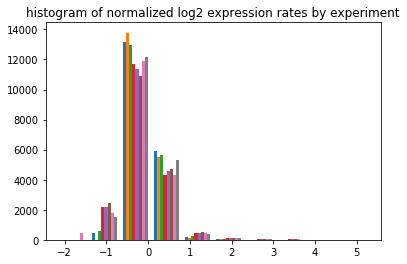

In [8]:
EXP_REP_activators = oligos_by_exp.loc[lambda x:x.mutant_num==0].groupby("exp").apply(lambda x: x.loc[x.mu > x.mu.quantile(.95)])
EXP_REP_repressors = oligos_by_exp.loc[lambda x:x.mutant_num==0].groupby("exp").apply(lambda x: x.loc[x.mu < x.mu.quantile(.05)])
EXP_REP_null = oligos_by_exp.loc[lambda x:x.mutant_num==0].groupby("exp").apply(lambda x: x.loc[x.mu < x.mu.quantile(.5)])

EXP_activator_oligos = EXP_REP_activators.groupby("exp_nm").apply(lambda g1:g1.loc[g1.oligo.isin(g1.set_index("rep").loc[1].oligo) & g1.oligo.isin(g1.set_index("rep").loc[2].oligo)])
EXP_repressor_oligos = EXP_REP_repressors.groupby("exp_nm").apply(lambda g1:g1.loc[g1.oligo.isin(g1.set_index("rep").loc[1].oligo) & g1.oligo.isin(g1.set_index("rep").loc[2].oligo)])
EXP_null_oligos = EXP_REP_null.groupby("exp_nm").apply(lambda g1:g1.loc[g1.oligo.isin(g1.set_index("rep").loc[1].oligo) & g1.oligo.isin(g1.set_index("rep").loc[2].oligo)])

EXP_activator_rep_rate =  EXP_activator_oligos.groupby(level="exp_nm").apply(lambda x:x.oligo.nunique()) / EXP_REP_activators.groupby("exp_nm").apply(lambda x:x.groupby("rep").oligo.nunique().mean())
EXP_repressor_rep_rate =  EXP_repressor_oligos.groupby(level="exp_nm").apply(lambda x:x.oligo.nunique()) / EXP_REP_repressors.groupby("exp_nm").apply(lambda x:x.groupby("rep").oligo.nunique().mean())
EXP_null_rep_rate =  EXP_null_oligos.groupby(level="exp_nm").apply(lambda x:x.oligo.nunique()) / EXP_REP_null.groupby("exp_nm").apply(lambda x:x.groupby("rep").oligo.nunique().mean())
#EXP_repressor_rep_rate =  EXP_repressor_oligos.groupby(level="exp_nm").reset_index("oligo").oligo.nunique().mean() / EXP_REP_repressors.groupby("exp_nm").reset_index("oligo").oligo.nunique()

DLD1_activator_rediscovery_rate = EXP_activator_rep_rate.loc["DLD1_WT"]
U2OS_activator_rediscovery_rate = EXP_activator_rep_rate.loc["U2OS_WT"]
MAX_activator_rediscovery_celltype = EXP_activator_rep_rate.idxmax()

pprint({
    "EXP_activators_mean_len":EXP_activator_oligos.groupby(level="exp_nm").oligo.nunique().mean(),
    "EXP_repressors_mean_len":EXP_repressor_oligos.groupby(level="exp_nm").oligo.nunique().mean(),
    "EXP_null_mean_len":EXP_null_oligos.groupby(level="exp_nm").oligo.nunique().mean(),
    "EXP_repressor__mean_rep_rate":EXP_repressor_rep_rate.mean(),
    "EXP_activator_mean_rep_rate":EXP_activator_rep_rate.mean(),
    "EXP_null_mean_rep_rate":EXP_null_rep_rate.mean(),
    "U2OS_activator_rediscovery_rate":U2OS_activator_rediscovery_rate,
    "DLD1_activator_rediscovery_rate":DLD1_activator_rediscovery_rate,
    "MAX_activator_rediscovery_celltype":MAX_activator_rediscovery_celltype,
    "EXP_activator_rep_rate": EXP_activator_rep_rate,
})


plt.gcf().set_size_inches(6,4)
ax = plt.gca()
plt.hist([(np.log2(g.mu) - np.log2(g.mu.mean())).rename(k) for k, g in oligos_by_exp.groupby("exp_nm")])

ax.set_title("histogram of normalized log2 expression rates by experiment")


Observing that APOBEC is expressed in DLD1 and U2OS cells, we defined a further set of activators defined as “APOBEC-on” enhancers, consisting of those enhancers which were identified both in the DLD1 replicates and the U2OS replicates, this set had {100} elements. Lastly, observing that APOBEC is not expressed in HCT116 cells, we defined a final set of activators of interest, consisting of {59} possible transcription activators which exhibited high transcription in U2OS and DLD1 cells (ie, in the APOBEC-on enhancers), but not in HCT116 cells. These were called “APOBEC-exclusive” candidate enhancer regions. Observing that U2OS expression tended to differ greatly with DLD1 expression, and U2OS expression was overall higher, we also investigated another set, "U2OS-on", with U2OS-identified enhancers, excluding those which were detected in HCT116 peaks.


In [9]:

APOBEC_on_oligo_ids = set(EXP_activator_oligos.loc["DLD1_WT"].oligo).intersection(EXP_activator_oligos.loc["U2OS_WT"].oligo)
APOBEC_sometimes_oligo_ids = set(EXP_activator_oligos.loc["DLD1_WT"].oligo).union(EXP_activator_oligos.loc["U2OS_WT"].oligo)
ABon_ids = APOBEC_on_oligo_ids
ABst_ids = APOBEC_sometimes_oligo_ids


APOBEC_exclusive_oligo_ids =APOBEC_on_oligo_ids.difference(EXP_activator_oligos.loc["HCT116_WT"].oligo)
U2OS_on_oligo_ids = set(EXP_activator_oligos.loc["U2OS_WT"].oligo)


ABex_ids = APOBEC_exclusive_oligo_ids 
U2on_ids = U2OS_on_oligo_ids
U2ex_ids = set(U2OS_on_oligo_ids).difference(EXP_activator_oligos.loc["HCT116_WT"].oligo)

ALLen_ids = set(EXP_activator_oligos.oligo)
WTst_ids =APOBEC_sometimes_oligo_ids.union(EXP_activator_oligos.loc["HCT116_WT"].oligo)


AB_differential_enhancer_ids = obe.loc[lambda x: x.oligo.isin(ABst_ids)].\
        loc[lambda df:abs(df.U2OS_WT_rank -df.DLD1_WT_rank) > 100].oligo.unique()

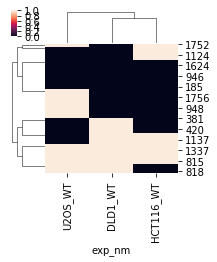

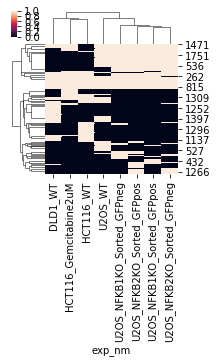

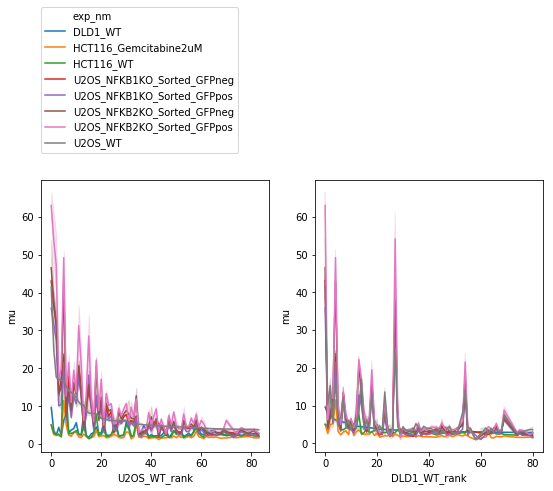

In [10]:

oligo_exp_activator_matrix = pd.Series(1, index =EXP_activator_oligos.oligo.to_frame().reset_index().set_index(["exp_nm","oligo"]).index).loc[lambda df: ~df.index.duplicated(keep='first') ].unstack("exp_nm").fillna(0)
oligo_exp_activator_matrix = oligo_exp_activator_matrix.append( [ pd.Series(0, index = oligo_exp_activator_matrix.columns).rename(o) for o in [e for e in obe.oligo.unique() if e not in oligo_exp_activator_matrix.index] ])
correlations = oligo_exp_activator_matrix.corr()
for nm in correlations.columns: correlations.loc[nm,nm] = 0

intersection_grid = np.array([[np.sum(oligo_exp_activator_matrix[c1].values * oligo_exp_activator_matrix[c2].values)
     for c1 in oligo_exp_activator_matrix.columns ]
     for c2 in oligo_exp_activator_matrix.columns])

sns.clustermap((oligo_exp_activator_matrix.loc[oligo_exp_activator_matrix.sum(axis=1) >0].filter(regex=".*WT.*" )),figsize=(3,3))
#sns.clustermap(oligo_exp_activator_matrix.filter(regex=".*WT.*" ).T.filter(regex=".*WT.*" ),figsize=(3,3))
sns.clustermap((oligo_exp_activator_matrix.loc[oligo_exp_activator_matrix.sum(axis=1) >0]),figsize=(3,3))

f,subs = plt.subplots(1,2)
f.set_size_inches(9,5)

plt.sca(subs[0])
sns.lineplot(x = "U2OS_WT_rank", y = "mu",  hue = "exp_nm", data = oligos_by_exp.loc[lambda x: x.oligo.isin(EXP_activator_oligos.loc["U2OS_WT"].oligo)])
plt.legend(loc=[0,1.1])

plt.sca(subs[1])
sns.lineplot(x = "DLD1_WT_rank", y = "mu",  hue = "exp_nm", data = oligos_by_exp.loc[lambda x: x.oligo.isin(EXP_activator_oligos.loc["DLD1_WT"].oligo)],legend=False)


#### Do enhancer regions exhibit differential activity in the cell types under study? ####
We had previously identified separate groups of top5% enhancers in each cell type under study. Furthermore, we observed that the groups of top5% enhancers were different for each of the cell types. To define APOBEC-on activators, we took an intersection of the top5% enhancers. To study differential expression in these cell types, we defined a new set of APOBEC-sometimes enhancer regions consisting of the union of top5% enhancer oligos in each of these (ABst) experiments. 



There were {100} total enhancer locations in the ABst set. For each enhancer, we examined the descending rank-sorted order of that enhancer in the experimental data for that locus, assigning a number equal to the absolute value of that rank sort-order difference in each set to each of the APOBEC-somstetimes enhancer regions. Looking at the full set of APOBEC-sometimes enhancer regions, we found a mean ranksort discrepancy of {248} between the two data sets. To quantify significance of this number, we also computed the mean ranksort discrepancy of the APOBEC-sometimes enhancers in each of the two experimental replicates of DLD1 and U2OS. We found that the average absolute ranksort differential of APOBEC-sometimes enhancer candidates was [111] and [49] in the DLD1 and U2OS replicates respectively, with an overall mean of [250]. Importantly, we found that amongst the U2OSon and DLD1on oligos, the average rank changes between replicates was 7.63 and 12.75 respectively, leading us to conclude that for the most expressed oligos, the expression rank change provided an internally consistent number.

Equipped with this measure, we set a threshold of rank expression change of 100 ranks and observed that 47 of the ABst potential enahncers changed in rank by 100 or more between the two experiments. We called these “APOBEC-differential-enhancers”, and noted that these 47 oligos were candidates for cell-type specific differential activation of APOBEC.


In [11]:
ranks_by_rep = oligos_by_exp.loc[lambda x:x.mutant_num == 0].groupby(["exp_type","rep"]).\
    apply(lambda x:x.groupby("oligo").mu.mean().sort_values(ascending=False).\
          reset_index().reset_index().set_index("oligo").\
        rename({"index":"ranksort"},axis="columns").\
        ranksort).unstack(level=0).rename(lambda x: x+"_rank",axis = "columns")

obe_w_repchanges = oligos_by_exp.join(
    (ranks_by_rep.loc[1] - ranks_by_rep.loc[2]).rename(lambda x:x+"_repchange",axis ="columns")
    ,on="oligo")

abst_U2OSNKFB_U2OS_WT_rankdiff = obe.loc[lambda x: x.oligo.isin(ABst_ids)].\
        apply(lambda df:abs(df.U2OS_WT_rank -df.U2OS_NFKB_rank),axis=1)

all_U2OSNKFB_U2OS_WT_rankdiff = obe.loc[lambda x:  x.mutant_num == 0].\
        apply(lambda df:abs(df.U2OS_WT_rank -df.U2OS_NFKB_rank),axis=1)

abst_dld1_U2OS_WT_rankdiff = obe.loc[lambda x: x.oligo.isin(ABst_ids)].\
        apply(lambda df:abs(df.U2OS_WT_rank -df.DLD1_WT_rank),axis=1)

all_dld1_U2OS_WT_rankdiff = obe.loc[lambda x: x.mutant_num == 0].\
        apply(lambda df:abs(df.U2OS_WT_rank -df.DLD1_WT_rank),axis=1)

AB_differential_enhancer_ids = obe.loc[lambda x: x.oligo.isin(ABst_ids)].\
        loc[lambda df:abs(df.U2OS_WT_rank -df.DLD1_WT_rank) > 100].oligo.unique()

print(f""" mean difference between rank sorts in U2OS vs DLD1 cells over--
   ABST oligos: ({abst_dld1_U2OS_WT_rankdiff.mean():.2f})  
   ALL wt oligos: ({all_dld1_U2OS_WT_rankdiff.mean():.2f})

Looking at only U2OS cell lines in NFKB-ko and NFKB designs, we find that the differences are reduced
   ABST oligos: ({abst_U2OSNKFB_U2OS_WT_rankdiff.mean():.2f})  
   ALL oligos: ({all_U2OSNKFB_U2OS_WT_rankdiff.mean():.2f})  


... and furthermore, that the rank change difference of expression levels amongst ABst expressed oligos is
reduced compared to the rank change difference between all oligos. In order to quantify the base level of
noise in rank fold change amongst all oligos, we looked at the average fold change difference between replicates,
finding that the overall change in expression ranks for 

ALL OLIGOS (U2OS) {obe_w_repchanges["U2OS_WT_rank_repchange"].abs().mean():.2f}
ABST OLIGOS (U2OS) {obe_w_repchanges.loc[lambda x: x.oligo.isin(ABst_ids)]["U2OS_WT_rank_repchange"].abs().mean():.2f}
ABST OLIGOS (U2OS) {obe_w_repchanges.loc[lambda x: x.oligo.isin(U2on_ids)]["U2OS_WT_rank_repchange"].abs().mean():.2f}


ALL OLIGOS (DLD1) {obe_w_repchanges["DLD1_WT_rank_repchange"].abs().mean():.2f}
ABST OLIGOS (DLD1) {obe_w_repchanges.loc[lambda x: x.oligo.isin(ABst_ids)]["DLD1_WT_rank_repchange"].abs().mean():.2f}
ABST OLIGOS (DLD1) {obe_w_repchanges.loc[lambda x: x.oligo.isin(EXP_activator_oligos.loc["DLD1_WT"].oligo)]["DLD1_WT_rank_repchange"].abs().mean():.2f}

Number of "APOBEC-differentialy-expressed" oligos:
    {len(AB_differential_enhancer_ids)} 

""")






 mean difference between rank sorts in U2OS vs DLD1 cells over--
   ABST oligos: (273.82)  
   ALL wt oligos: (324.79)

Looking at only U2OS cell lines in NFKB-ko and NFKB designs, we find that the differences are reduced
   ABST oligos: (111.69)  
   ALL oligos: (274.94)  


... and furthermore, that the rank change difference of expression levels amongst ABst expressed oligos is
reduced compared to the rank change difference between all oligos. In order to quantify the base level of
noise in rank fold change amongst all oligos, we looked at the average fold change difference between replicates,
finding that the overall change in expression ranks for 

ALL OLIGOS (U2OS) 265.13
ABST OLIGOS (U2OS) 81.38
ABST OLIGOS (U2OS) 8.24


ALL OLIGOS (DLD1) 295.02
ABST OLIGOS (DLD1) 111.68
ABST OLIGOS (DLD1) 12.57

Number of "APOBEC-differentialy-expressed" oligos:
    54 




Starting from this measure of differential expression in wild-type cells that were highly expressive of APOBEC, we sought to apply the same measure to quantification of differential expression between the APOBEC-expressing cell lines and the HCT116 cell type which does not natively express APOBEC. Defining an inclusive set of enhancers, WILDTYPE-activators with [XXX] members, consisting of the top5% enhancers from DLD1, HCT116, and U2OS, we looked at differential expression, computed between all 3x3 cell types for each of these enhancers. We were also curious to see how differential expression of the bot5% would vary between these three cell types and therefore defined the set WILDTYPE-repressors and computed the same score, using all 3x3 comparisons.

Using the same definitions above, we computed average and std deviation of ranksort discrepancies for activators ( [XXX]mean, [XXX]stddev ) and repressors  ( [XXX]mean, [XXX]stddev )  individually and identified as differentially expressed all those oligos which crossed the threshold of mean + 1 std discrepancy change. By this measure, we found that [XXX] / ([XXX]) oligos were differentially expressed between either DLD1 / (U2OS) and HCT116 cells respectively. We called their intersection, the “APOBEC-on-enhancers” (XXX regions). Comparing the set of oligos previously identified as in the DLD1 and U2OS sets but not in HCT116 cells (“ABOPEC-exclusive” oligos), we found that [XXX]% of APOBEC-exclusive oligos were found in this set of differentially expressed oligos, confirming the internal consistency of these two measures. 

In [12]:

obe_wtst = obe.loc[lambda x: x.oligo.isin(WTst_ids) ]
celltypes = pd.Series(["DLD1_WT","U2OS_WT","HCT116_WT"], index = ["DLD1_WT","U2OS_WT","HCT116_WT"])
exptypes = pd.Series(obe.exp_type.unique(), index = obe.exp_type.unique())

enhancer_intersection_sizes = celltypes.apply(lambda x: celltypes.apply(lambda y:len(
    set(EXP_activator_oligos.loc[x].oligo.unique()).intersection(
    set(EXP_activator_oligos.loc[y].oligo.unique())))))

WTst_differential_expression_count = \
exptypes.apply(lambda ct1: 
        exptypes.apply(lambda ct2:
            len(set(obe_wtst.loc[lambda x:(abs(x[ct1 + "_rank"]  - x[ct2+"_rank"])) > 100].oligo.unique()))))





print(f"""
number of oligos highly expressed in at least one of: DLD1, U2OS, HCT116 WILDTYPE CELLS: {len(WTst_ids)}

Looking at the number of differentially expressed transcripts by delta-rank > 100 metric in each cell type, we
get:
   U2OS --> DLD1 {WTst_differential_expression_count.loc["U2OS_WT","DLD1_WT"]}
   U2OS --> HTC116 {WTst_differential_expression_count.loc["U2OS_WT","HCT116_WT"]}
   DLD1 --> HCT116 {WTst_differential_expression_count.loc["DLD1_WT","HCT116_WT"]}
   
Counts of differentially expressed transcripts in each cell type.

Looking at experiment type changes, we find 
   U2OS_WT --> U2OS_NFKB_KO {WTst_differential_expression_count.loc["U2OS_WT","U2OS_NFKB"]}
   HCT116_WT --> HCT116_GEM {WTst_differential_expression_count.loc["HCT116_WT","HCT116_GEM"]}
      """)



number of oligos highly expressed in at least one of: DLD1, U2OS, HCT116 WILDTYPE CELLS: 124

Looking at the number of differentially expressed transcripts by delta-rank > 100 metric in each cell type, we
get:
   U2OS --> DLD1 63
   U2OS --> HTC116 62
   DLD1 --> HCT116 45
   
Counts of differentially expressed transcripts in each cell type.

Looking at experiment type changes, we find 
   U2OS_WT --> U2OS_NFKB_KO 38
   HCT116_WT --> HCT116_GEM 49
      


### Do enhancer regions exhibit differential activity in the cell types under study? ###
We had previously identified separate groups of top5% enhancers in each cell type under study. Furthermore, we observed that the groups of top5% enhancers were different for each of the cell types. To define APOBEC-on activators, we took an intersection of the top5% enhancers. To study differential expression in these cell types, we defined a new set of APOBEC-sometimes enhancer regions consisting of the union of top5% enhancer oligos in each of these experiments. 

There were [XXX] total enhancer locations in this set. For each enhancer, we examined the descending rank-sorted order of that enhancer in the experimental data for that locus, assigning a number equal to the absolute value of that rank sort-order difference in each set to each of the APOBEC-somstetimes enhancer regions. Looking at the full set of APOBEC-sometimes enhancer regions, we found a mean ranksort discrepancy of [XXX] between the two data sets. To quantify significance of this number, we also computed the mean ranksort discrepancy of the APOBEC-sometimes enhancers in each of the two experimental replicates of DLD1 and U2OS. We found that the average absolute ranksort differential of APOBEC-sometimes enhancer candidates was [XXX] and [XXX] in the DLD1 and U2OS replicates respectively, with an overall mean of [XXX] and overall standard deviation of [XXX]. We set a threshold of [XXX], which was the mean discrepancy + 1 STD as the ranksort discrepancy to define a given enhancer oligo as differentially activating between the two cell types and found that amongst the [XXX] oligos in APOBEC-sometimes, [XXX] ([XXX]%) “APOBEC-differential-activators”, were differentially expressed by this measure.

Starting from this measure of differential expression in wild-type cells that were highly expressive of APOBEC, we sought to apply the same measure to quantification of differential expression between the APOBEC-expressing cell lines and the HCT116 cell type which does not natively express APOBEC. Defining an inclusive set of enhancers, WILDTYPE-activators with [XXX] members, consisting of the top5% enhancers from DLD1, HCT116, and U2OS, we looked at differential expression, computed between all 3x3 cell types for each of these enhancers. We were also curious to see how differential expression of the bot5% would vary between these three cell types and therefore defined the set WILDTYPE-repressors and computed the same score, using all 3x3 comparisons.

Using the same definitions above, we computed average and std deviation of ranksort discrepancies for activators ( [XXX]mean, [XXX]stddev ) and repressors  ( [XXX]mean, [XXX]stddev )  individually and identified as differentially expressed all those oligos which crossed the threshold of mean + 1 std discrepancy change. By this measure, we found that [XXX] / ([XXX]) oligos were differentially expressed between either DLD1 / (U2OS) and HCT116 cells respectively. We called their intersection, the “APOBEC-on-enhancers” (XXX regions). Comparing the set of oligos previously identified as in the DLD1 and U2OS sets but not in HCT116 cells (“ABOPEC-exclusive” oligos), we found that [XXX]% of APOBEC-exclusive oligos were found in this set of differentially expressed oligos, confirming the internal consistency of these two measures. 




In [13]:
diffex = exptypes.apply(lambda ct1: 
        exptypes.apply(lambda ct2:
            obe_wtst.loc[lambda x:(x[ct1 + "_rank"]  - x[ct2+"_rank"]) > 100].oligo.unique())).stack()\
    .groupby(level=[0,1]).apply(lambda x:pd.Series([e for i,e in enumerate(x.values[0])]))

diffex = diffex.rename("oligo").reset_index(level=2,drop=True)
diffex = diffex.rename_axis(["expressed","unexpressed"]).reset_index()


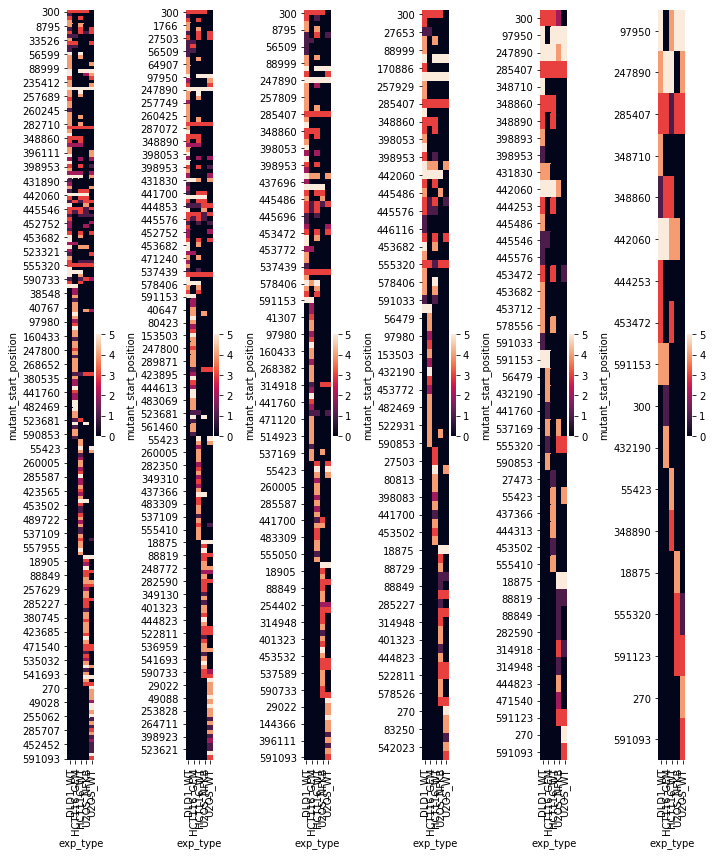

In [148]:
sns.set_palette("husl")
f,subs = plt.subplots(1,quantiles["quantile"].nunique())
f.set_size_inches(10,12)
for i,q in enumerate(sorted(quantiles["quantile"].unique())):
    plt.sca(subs[i])
    data = quantiles.loc[lambda df:df["quantile"]==q]
    sns.heatmap( data = (data["filter_color"]*(data["ks_pval"]<.1)).loc[lambda x:x>0].unstack(level=0).fillna(0))

plt.tight_layout()

### Which motifs are found in motif activator / repressor candidates? ###
In the above section, we identified the 30 base pair mutations which had a statistically significant differential expression compared to the combined set of overlapping wild type and mutant oligos. Now, we are interested in joining this data with the motif hit information computed above to identify candidate motifs influencing expression levels. Note that the p values for mutants above treat activation and repression equivalently, therefore this step will identify both candidate activators and candidate repressors


### Which motifs instances falling in 30 BP enhancer candidates are significant above each threshold value? ###
Using the definitions of affine motif log odds scores for the instances identified above, compute the total number of motif hits which are identified overall at that significance range. 


In [243]:


# join the motif hits with mutation data, accepting only hits which fall above a given affine score
# later in the process, we will model affine scores using a statistical model
affine_scores = [0,1,2,3,5]
qjoin_afs = pd.concat([
 pd.merge(
    quantiles.reset_index(),
    motif_oligos_data.dropna(subset =["target_mutant_start_position"]).loc[lambda x: x.affine_score > afs],
    right_on="target_mutant_start_position",
    left_on="mutant_start_position").assign(affine_score_threshold = afs)
    for afs in affine_scores],axis=0)
                                                                                     




In [234]:
motif_filter_color_counts = pd.DataFrame()
for q in quantiles["quantile"].unique():
    qsel = qjoin_afs.loc[lambda x: x["quantile"] == q] 
    temp = qsel.groupby(['jaspar_id','exp_type',"affine_score_threshold"]).filter_color.value_counts().rename("fc_count")
    affine_total_hit_counts = temp.reset_index().set_index("affine_score_threshold").groupby("affine_score_threshold").apply(lambda x: x.set_index('jaspar_id')\
                                                           .join(motif_oligos_data.loc[lambda y:y.affine_score>x.name]\
                                                                 .groupby(['jaspar_id']).size().rename("n_total_hits")))           

    
    motif_filter_color_counts = motif_filter_color_counts.append(
        temp.reset_index().set_index("affine_score_threshold").groupby("affine_score_threshold").apply(lambda x: x.set_index('jaspar_id')\
                                                           .join(motif_oligos_data.loc[lambda y:y.affine_score>x.name]\
                                                                 .groupby(['jaspar_id']).size().rename("n_total_hits")))\
               .reset_index().set_index(["jaspar_id","exp_type","affine_score_threshold", "filter_color"]).assign(quantile=q))
motif_filter_color_counts = motif_filter_color_counts.set_index("quantile",append=True)


In [129]:
affine_stds = [0,.25,.5,1,2,3]
qjoin_afs_z = pd.concat([
 pd.merge(
    quantiles.reset_index(),
    motif_oligos_data.dropna(subset =["target_mutant_start_position"])\
     .loc[lambda x: x.affine_score > (x.score_mean+x.score_std*afstd)],
    right_on="target_mutant_start_position",
    left_on="mutant_start_position").assign(affine_zscore_threshold = afstd)
    
    for afstd in affine_stds],axis=0)


qsel = qjoin_afs_z.loc[lambda x: x["quantile"] == base_quantile] 
temp = qsel.groupby(['jaspar_id','exp_type',"affine_zscore_threshold"]).filter_color.value_counts().rename("fc_count")
affine_total_zs_counts = temp.reset_index().set_index("affine_zscore_threshold").groupby("affine_zscore_threshold").apply(lambda x: x.set_index('jaspar_id')\
                                                           .join(motif_oligos_data.loc[lambda y:y.affine_score>x.name]\
                                                                 .groupby(['jaspar_id']).size().rename("n_total_hits")))           



In [ ]:
#TODO FILL BACK IN
rel = []

In [244]:
quantiles.exp_type.unique()

AttributeError: 'DataFrame' object has no attribute 'exp_type'

In [319]:
qjoin_afs =  qjoin_afs.join(jaspar.name.str.extract("(VDR|FOS|REL)")[0].rename("family"),on = "jaspar_id")

In [320]:
relb_quantiles = qjoin_afs.loc[lambda x: x.jaspar_id.isin(rel.index)]
relb_quantiles = relb_quantiles.loc[lambda x:x.exp_type.str.contains("U2OS")]
relb_quantiles = relb_quantiles.join(jaspar[["name"]], on = "jaspar_id")
relb_quantiles["genomic_position"] = relb_quantiles.target_mutant_start_position + region_bounds[0]
relb_sub_quantiles = relb_quantiles.loc[lambda x: (x.genomic_position > 3.92e7) &( x.genomic_position > 3.92e3)]


ValueError: columns overlap but no suffix specified: Index(['name'], dtype='object')

In [ ]:
f,subs = plt.subplots(1)
f.set_size_inches(12,4)

# plt.sca(subs[0])
# sns.scatterplot(y = "affine_score", hue="exp_type",  x =relb_quantiles.target_mutant_start_position + region_bounds[0], data = relb_quantiles, legend=False)
plt.sca(subs)
sns.scatterplot(y = "log_ks_pval" , hue="name",x ="genomic_position", data = relb_sub_quantiles)
# plt.sca(subs[2])
# sns.scatterplot(y = "filterchange" , hue="exp_type", x =relb_quantiles.target_mutant_start_position + region_bounds[0], data = relb_quantiles)


plt.tight_layout()


In [282]:
qjoin_afs = qjoin_afs.join(jaspar[["name"]], on = "jaspar_id")

In [304]:
relb_quantiles = qjoin_afs.loc[lambda x: x.affine_score > 10].loc[lambda x: x.name.str.contains("FOS")] #.loc[lambda x: x.jaspar_id.isin(rel.index)]

In [302]:
len(relb_quantiles)

30240

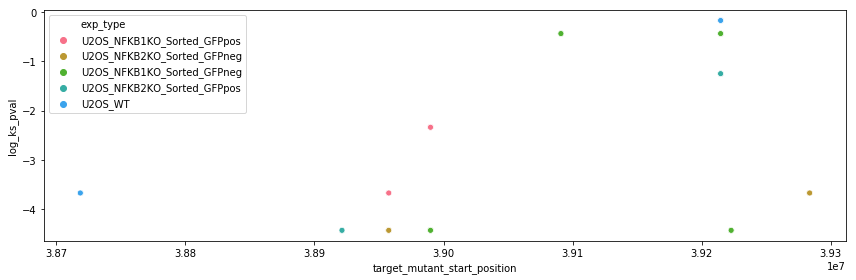

In [305]:
#relb_quantiles = qjoin_afs.loc[lambda x: x.affine_score > 3].loc[lambda x: x.name.str.contains("FOS")] #.loc[lambda x: x.jaspar_id.isin(rel.index)]
relb_quantiles = relb_quantiles.loc[lambda x:x.exp_type.str.contains("U2OS")]
relb_quantiles["genomic_position"] = relb_quantiles.target_mutant_start_position + region_bounds[0]
relb_sub_quantiles = relb_quantiles.loc[lambda x: (x.genomic_position > 3.92e7) &( x.genomic_position > 3.92e3)]



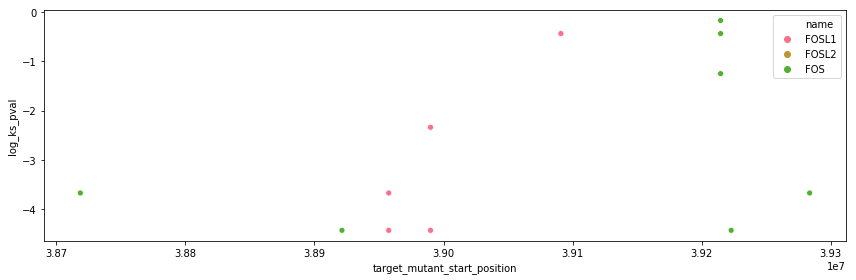

In [306]:
f,subs = plt.subplots(1)
f.set_size_inches(12,4)
plt.sca(subs)
sns.scatterplot(y = "log_ks_pval" , hue="name",x =relb_quantiles.target_mutant_start_position + region_bounds[0], data = relb_quantiles)
plt.tight_layout()


In [307]:
relb_quantiles = qjoin_afs.loc[lambda x: x.name.str.contains("VDR")]

In [314]:
qjoin_afs =  qjoin_afs.join(jaspar.name.str.extract("(VDR|FOS|REL)"),on = "jaspar_id")

In [ ]:
families

In [308]:
len(relb_quantities)

NameError: name 'relb_quantities' is not defined

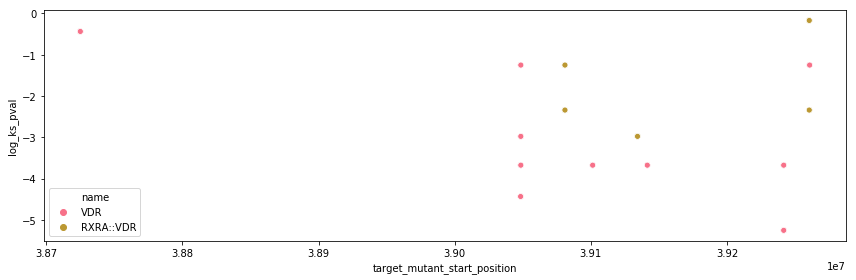

In [312]:
#relb_quantiles = qjoin_afs.loc[lambda x: x.name.str.contains("VDR")] #.loc[lambda x: x.jaspar_id.isin(rel.index)]
relb_quantiles = relb_quantiles.loc[lambda x:x.exp_type.str.contains("U2OS")]
relb_quantiles["genomic_position"] = relb_quantiles.target_mutant_start_position + region_bounds[0]
relb_sub_quantiles = relb_quantiles.loc[lambda x: (x.genomic_position > 3.92e7) &( x.genomic_position > 3.92e3)]
f,subs = plt.subplots(1)
f.set_size_inches(12,4)
plt.sca(subs)
sns.scatterplot(y = "log_ks_pval" , hue="name",x =relb_quantiles.target_mutant_start_position + region_bounds[0], data = relb_quantiles)
plt.tight_layout()


In [ ]:
jaspar.name.apply

In [ ]:
jaspar.family = jaspar.name.apply(lambda x: "VDR" if "VDR" in x else ("FOS" if "FOS" in  else ))

In [ ]:
relb_quantiles.name.str.contains('|'.join(searchfor))]

In [263]:
qjoin_afs["genomic_position"] = qjoin_afs.target_mutant_start_position + region_bounds[0]

In [334]:

LIN_OUTPUT = qjoin_afs[["name","exp_type","log_ks_pval","genomic_position"
                , 'allothers', 'onlyablations','allothers2','onlyablations2',
               "affine_score","family"]]\
    .rename({"name":"Jaspar Motif Name",
            "exp_type":"Experiment Name",
             "genomic_position":"30bp Genomic Start",
             "allothers": "30bp Non-ablation Oligo mu",
             "onlyablations": "30 bp Ablation Oligo mu",
             "allothers2": "60bp Non-ablation Oligo mu",
             "onlyablations2": "60 bp Ablation Oligo mu",
             "affine_score": "Motif Score",
             
            },axis="columns").drop_duplicates()

In [329]:
import os

In [330]:
if not os.path.isdir("../analyses"):
    os.makedirs("../analyses")

In [331]:
LIN_OUTPUT.to_csv("../analyses/0917_all_motif_hit.csv")

In [341]:
LIN_OUTPUT.loc[lambda x: x.family == "REL"]["Experiment Name"].unique()#loc[lambda x: x["Experiment Name"] == "HCT116_GEM"]

array(['DLD1_WT', 'HCT116_WT', 'U2OS_NFKB1KO_Sorted_GFPpos',
       'U2OS_NFKB2KO_Sorted_GFPpos', 'U2OS_WT', 'HCT116_Gemcitabine2uM',
       'U2OS_NFKB2KO_Sorted_GFPneg', 'U2OS_NFKB1KO_Sorted_GFPneg'],
      dtype=object)

In [347]:
# pd.concat([LIN_OUTPUT.loc[lambda x: x.family == "REL"].loc[lambda x: x["Experiment Name"] == "HCT116_WT"].drop_duplicates(subset=["30bp Genomic Start"]).set_index("30bp Genomic Start")["log_ks_pval"],
#            LIN_OUTPUT.loc[lambda x: x.family == "REL"].loc[lambda x: x["Experiment Name"] == "HCT116_Gemcitabine2uM"].drop_duplicates(subset=["30bp Genomic Start"]).set_index("30bp Genomic Start")["log_ks_pval"]],axis=1)

In [348]:
LIN_OUTPUT

,Jaspar Motif Name,Experiment Name,log_ks_pval,30bp Genomic Start,30bp Non-ablation Oligo mu,30 bp Ablation Oligo mu,60bp Non-ablation Oligo mu,60 bp Ablation Oligo mu,Motif Score,family
0,MZF1,DLD1_WT,-3.674402,38700034.0,3.580733,2.387749,3.584413,2.900763,0.643786,NaN
1,MZF1(var.2),DLD1_WT,-3.674402,38700034.0,3.580733,2.387749,3.584413,2.900763,0.080006,NaN
2,Pax2,DLD1_WT,-3.674402,38700034.0,3.580733,2.387749,3.584413,2.900763,0.062641,NaN
3,SPIB,DLD1_WT,-3.674402,38700034.0,3.580733,2.387749,3.584413,2.900763,2.291421,NaN
4,HOXA5,DLD1_WT,-3.674402,38700034.0,3.580733,2.387749,3.584413,2.900763,0.406679,NaN
5,Nr2e3,DLD1_WT,-3.674402,38700034.0,3.580733,2.387749,3.584413,2.900763,1.833527,NaN
6,Nr2e3,DLD1_WT,-3.674402,38700034.0,3.580733,2.387749,3.584413,2.900763,0.833527,NaN
7,TEAD1,DLD1_WT,-3.674402,38700034.0,3.580733,2.387749,3.584413,2.900763,1.316884,NaN
8,TEAD4,DLD1_WT,-3.674402,38700034.0,3.580733,2.387749,3.584413,2.900763,1.244821,NaN
19,HOXA5,DLD1_WT,-3.674402,38700034.0,3.580733,2.387749,3.584413,2.900763,0.237603,NaN


In [249]:
relb_quantiles.colaumnsa


Index(['exp_type', 'mutant_start_position', 'allothers', 'onlyablations',
       'allothers2', 'allothersstd', 'std', 'onlyablations2', 'othermutants',
       'onlywildtype', 'ks_pval', 'ks2_pval', 'ks_stat', 'mutdiff', 'wtdiff',
       'othersdiff', 'rank_mutdiff', 'rank_ao', 'rank_ao_dld1', 'rank_ao_u2os',
       'rank_ao_hct116', 'filterchange', 'ks_1or2', 'log_ks_pval',
       'ablation_mu_filtered', 'wt_filtered', 'change_filtered',
       'both_filtered', 'both_ablation_filtered', 'filter_color', 'quantile',
       'motif_oligo_idx', 'hit_type', 'oligo', 'motif_hit_idx',
       'is_overlapping_wt', 'is_ablation_mut', 'is_benign_mut', 'jaspar_id',
       'position', 'score', 'mu', 'seq_actual', 'threshold_fdr_005',
       'threshold_fdr_05', 'threshold_balanced', 'threshold_patser',
       'threshold_bal', 'affine_score', 'target_mutant_start_position',
       'score_std', 'score_mean', 'affine_score_threshold', 'name'],
      dtype='object')

In [247]:
print("DONE")

DONE


In [143]:
motif_oligos_data.oligo.nunique()

9903

In [141]:
len(motif_oligos_data)

2276105

### Which motifs have the highest % of instances falling in interesting regions? ###
Before moving on, we were interested in ranking motifs by the fraction of instances falling interesting regions overall. This will provide a consistent axis for future plots.

In [20]:
motif_fcc_selected =  \
    motif_filter_color_counts.reset_index().loc[lambda x: (x["quantile"] ==.75) & (x["affine_score_threshold"] ==0)]
jaspar_overall_frac_interesting = (motif_fcc_selected.loc[lambda x:x.filter_color>0].groupby("jaspar_id").fc_count.sum()/\
    motif_fcc_selected.groupby("jaspar_id").fc_count.sum()).fillna(0).rename("fraction_interesting")
jaspar_overall_rank = jaspar_overall_frac_interesting.reset_index().sort_values("fraction_interesting",ascending=False)\
    .reset_index().set_index("jaspar_id")["index"].rename("motif_rank_index")
motif_filter_color_counts = motif_filter_color_counts.join(jaspar_overall_rank,on="jaspar_id")


### What fraction of each jaspar motif are interesting according to various measures? ###
Motif instances can be interesting because they correspond to (1) highly expressed oligos, (2) differentially expressed oligos, or (3) both. Set (3) will be the principal focus of future sections when we look for activator motifs, however set (2) will be useful when we look for repressors. 


In [21]:
frac_motif_enriched6 = (motif_filter_color_counts.reset_index("filter_color").groupby(["jaspar_id","exp_type","affine_score_threshold","quantile"])\
    .apply(lambda x:  x.set_index("filter_color").loc[6].fc_count.sum() if (6 in x.filter_color.values )  else 0 ) /\
        motif_filter_color_counts.reset_index(level=4).n_total_hits.loc[~motif_filter_color_counts.reset_index(level=4).index.duplicated()])\
            .rename("color_6_enrichment")

frac_motif_enriched5 = (motif_filter_color_counts.reset_index("filter_color").groupby(["jaspar_id","exp_type","affine_score_threshold","quantile"])\
    .apply(lambda x:  x.set_index("filter_color").loc[5].fc_count.sum() if (5 in x.filter_color.values )  else 0 ) /\
        motif_filter_color_counts.reset_index(level=4).n_total_hits.loc[~motif_filter_color_counts.reset_index(level=4).index.duplicated()])\
            .rename("color_5_enrichment")

frac_motif_enriched4 = (motif_filter_color_counts.reset_index("filter_color").groupby(["jaspar_id","exp_type","affine_score_threshold","quantile"])\
    .apply(lambda x:  x.set_index("filter_color").loc[4].fc_count.sum() if (4 in x.filter_color.values )  else 0 ) /\
        motif_filter_color_counts.reset_index(level=4).n_total_hits.loc[~motif_filter_color_counts.reset_index(level=4).index.duplicated()])\
            .rename("color_4_enrichment")

frac_motif_enriched3 = (motif_filter_color_counts.reset_index("filter_color").groupby(["jaspar_id","exp_type","affine_score_threshold","quantile"])\
    .apply(lambda x:  x.set_index("filter_color").loc[3].fc_count.sum() if (3 in x.filter_color.values )  else 0 ) /\
        motif_filter_color_counts.reset_index(level=4).n_total_hits.loc[~motif_filter_color_counts.reset_index(level=4).index.duplicated()])\
            .rename("color_3_enrichment")

frac_motif_enriched2 = (motif_filter_color_counts.reset_index("filter_color").groupby(["jaspar_id","exp_type","affine_score_threshold","quantile"])\
    .apply(lambda x:  x.set_index("filter_color").loc[2].fc_count.sum() if (2 in x.filter_color.values )  else 0 ) /\
        motif_filter_color_counts.reset_index(level=4).n_total_hits.loc[~motif_filter_color_counts.reset_index(level=4).index.duplicated()])\
            .rename("color_2_enrichment")

frac_motif_enriched1 = (motif_filter_color_counts.reset_index("filter_color").groupby(["jaspar_id","exp_type","affine_score_threshold","quantile"])\
    .apply(lambda x:  x.set_index("filter_color").loc[1].fc_count.sum() if (1 in x.filter_color.values )  else 0 ) /\
        motif_filter_color_counts.reset_index(level=4).n_total_hits.loc[~motif_filter_color_counts.reset_index(level=4).index.duplicated()])\
            .rename("color_1_enrichment")

ordered_cols = ["jaspar_id",  "exp_type",   "affine_score_threshold",  "quantile", "filter_color"]
motif_filter_color_counts = motif_filter_color_counts.join(frac_motif_enriched1, on =ordered_cols)\
    .join(frac_motif_enriched2, on =ordered_cols)\
    .join(frac_motif_enriched3, on =ordered_cols)\
    .join(frac_motif_enriched4, on =ordered_cols)\
    .join(frac_motif_enriched5, on =ordered_cols)\
    .join(frac_motif_enriched6, on =ordered_cols)


In [22]:
HCT_CANDIDATES = motif_filter_color_counts.reset_index().\
    loc[lambda df: df.exp_type.isin(["U2OS_WT","U2OS_NFKB","HCT116_WT","HCT116_GEM","DLD1_WT"])].\
    loc[lambda df: (df["quantile"] == .95) & (df["affine_score_threshold"] == 2)  & (df["filter_color"] == 3)]
HCT_CANDIDATES.set_index(["exp_type","jaspar_id"]).color_3_enrichment.unstack().T.join(jaspar.name)

,DLD1_WT,HCT116_GEM,HCT116_WT,U2OS_NFKB,U2OS_WT,name
jaspar_id,,,,,,
16,0.003102,0.003102,0.003102,0.003749,0.003749,Pax2
25,0.041787,0.041787,0.041787,0.041787,NaN,SPIB
28,NaN,NaN,NaN,0.017428,0.017428,MAFG::NFE2L1
30,NaN,NaN,NaN,0.063181,0.063181,Hand1::Tcf3
31,NaN,NaN,NaN,0.038350,0.038350,REL
32,NaN,NaN,NaN,0.224299,0.224299,RELA
34,0.003324,0.003324,0.003324,NaN,NaN,HLTF
35,0.014286,0.014286,0.014286,NaN,NaN,Spz1
40,0.002819,0.002819,0.002819,NaN,NaN,ZNF354C


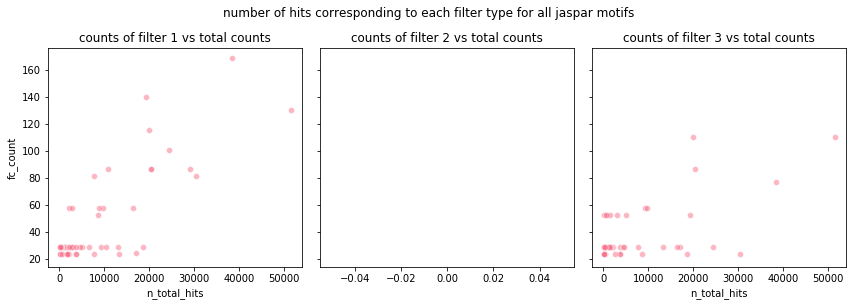

In [23]:
f,subs = plt.subplots(1,3,sharey = True)
f.set_size_inches(12,4)
f.suptitle("number of hits corresponding to each filter type for all jaspar motifs",y=1.05)

for e in range(1,4):
    plt.sca(subs[e-1])
    sns.scatterplot( x = "n_total_hits", y = "fc_count",alpha=.5,
                    data =motif_filter_color_counts.reset_index().loc[lambda x:(x["quantile"]==.95 ) &( x["filter_color"]==e )& (x.exp_type=="U2OS_WT")],
                    )
    plt.gca().set_title(f"counts of filter {e} vs total counts")
    
f.tight_layout()

### Which motifs are of interest for further investigation? ###
Having computed a set of motif statistics, most important the number and fraction of motif instances having an affine score greater than a threshold value which show up transcripts exhibiting high levels of basal expression + differential mutant expression. For this experiment, we use the 90% percent quantile, which means that all quantities, including:
 1. wildtype mubar cutoffs
 2. ablation mubar cutoffs
 3. absolute value differential expression cutoffs

Are labeled as "on" when they fall in 90th percentile

In [24]:
base_quantile =.95
base_afs = 0

motifs_of_interest = motif_filter_color_counts.reset_index()\
    .loc[lambda x:(x["quantile"] ==base_quantile) & (x["affine_score_threshold"] == base_afs) & 
         ((x["color_1_enrichment"]+x["color_2_enrichment"]+x["color_3_enrichment"]+
          x["color_4_enrichment"]+x["color_5_enrichment"]+x["color_6_enrichment"]) > 0) ]


#### Which motifs are of interest in each cell type by the above definition? ####


In [25]:
tmp =motifs_of_interest.reset_index()\
    .loc[lambda x:x.affine_score_threshold==base_afs]\
    .loc[lambda x:x["quantile"]==base_quantile]\
    .set_index(["jaspar_id","exp_type","filter_color"]).filter(regex="color_\d_enrichment")\
    .reset_index("filter_color")

In [26]:
colors = motifs_of_interest.reset_index()\
    .loc[lambda x:x.affine_score_threshold==base_afs]\
    .loc[lambda x:x["quantile"]==base_quantile]\
    .set_index(["jaspar_id","exp_type","filter_color"])\
    .reset_index("filter_color").loc[lambda x:~x.index.duplicated()].filter(regex="color_\d_enrichment")


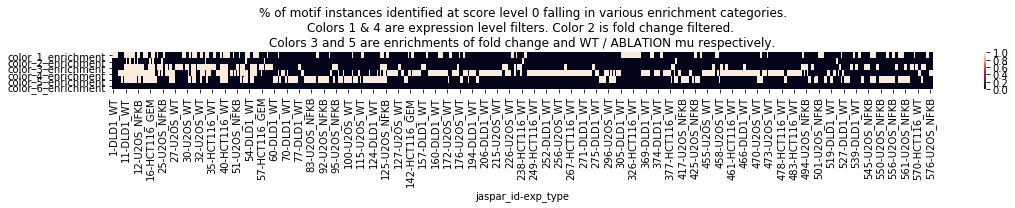

In [27]:

f = plt.gcf()
ax = plt.gca()
ax.set_title(f"""% of motif instances identified at score level {base_afs} falling in various enrichment categories.
Colors 1 & 4 are expression level filters. Color 2 is fold change filtered. 
Colors 3 and 5 are enrichments of fold change and WT / ABLATION mu respectively.""")
f.set_size_inches(16,3)
sns.heatmap(colors.T>0,square=False)
plt.tight_layout()

In [28]:
colors.columns.name="color_name"

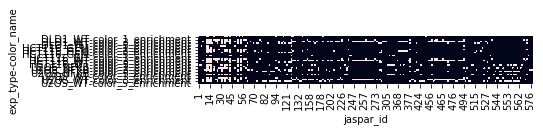

In [29]:
sns.heatmap(colors.unstack("exp_type").fillna(0).T.reset_index().set_index(["exp_type","color_name"]).sort_index() > 0,square =True,cbar=False)



### Which motifs behave as activators and which behave as repressors? ###
Using the "colors" map above, we focus on motif types (color_3) and (color_5), having instances which both exhibit a significant fold expression change (fold change pval threshold defined by quantiles, above) and an enrichment of expression in either wild type or mutant oligos. We will initially compute the analysis using the base affine p value, to determine which motifs have --any-- instances in either category, and then make a plot which for each motif, computes the STD of affine p value and plots the fraction of motifs falling above threshold for instances at each z-score.

We will begin this analysis by taking a max over all experiment types.


In [30]:

colors_by_color_exp = colors.unstack("exp_type").fillna(0).T.reset_index().set_index(["exp_type","color_name"])
colors_by_color = colors_by_color_exp.groupby("color_name").max()
c3 = colors_by_color.T.color_3_enrichment
c5 = colors_by_color.T.color_5_enrichment

c3_vals = c3.loc[c3>0].rename("c3_vals")
c5_vals = c5.loc[c5>0].rename("c5_vals")

activator_ids = set(c3_vals.loc[lambda x: x>0].index.unique())
repressor_ids = set(c5_vals.loc[lambda x: x>0].index.unique())

print(f"""
Identified subsets of activator and repressor motifs.

n_activators {len(activator_ids)}
n_repressors {len(repressor_ids)}
n_both {len(set(activator_ids).intersection(repressor_ids))}

""")



Identified subsets of activator and repressor motifs.

n_activators 50
n_repressors 75
n_both 16




#### Looking more deeply into the motifs of interest, what are the are the std and means of their affine scores? ####
Having identified candidate motifs of interest in the step above, we now which to pick specific instances that will be subject to further investigation. To do this, we compute that distributions of affine scores for each motif. These will be used to compute the significance of each motif hit identified above. From the

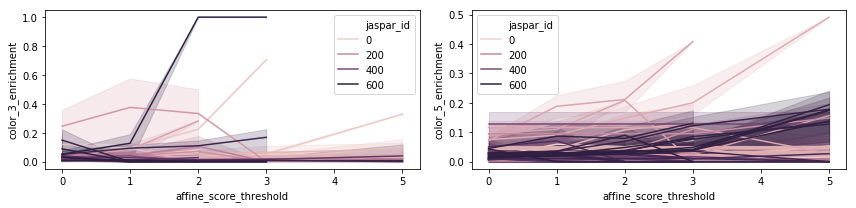

In [31]:
f,subs = plt.subplots(1,2)
f.set_size_inches(12,3)
plt.sca(subs[0])
sns.lineplot(x = "affine_score_threshold", y="color_3_enrichment", hue="jaspar_id",
             data = motif_filter_color_counts.reset_index().loc[
    lambda x: (x["quantile"] ==.75) & x.jaspar_id.isin(activator_ids)])

plt.sca(subs[1])
sns.lineplot(x = "affine_score_threshold", y="color_5_enrichment", hue="jaspar_id",
             data = motif_filter_color_counts.reset_index().loc[
    lambda x: (x["quantile"] ==.75) & x.jaspar_id.isin(repressor_ids)])
plt.tight_layout()

In [35]:
background = dict([[l,chrseq[region_bounds[0]:region_bounds[1]].count(l) / len(chrseq[region_bounds[0]:region_bounds[1]])] for l in "ATGC"])


In [36]:
#load motifs
from Bio.motifs import jaspar as mjaspar
import Bio.motifs
from Bio import motifs as bmotifs
with open("../data/jaspar.pfm") as handle:
    jaspar_motifs = mjaspar._read_jaspar(handle)

for j in jaspar_motifs:
     j.pseudocounts =1   


In [37]:
dists =   pd.Series({aid:jaspar_motifs[aid].pssm.distribution(background=background)for aid in activator_ids})

In [38]:
jaspar_fdrs = pd.concat([
    pd.Series(v).rename(k)
    for k,v in {
    "fdr_001":dists.apply(lambda d: d.threshold_fpr(.001)),
        "fdr_002":dists.apply(lambda d: d.threshold_fpr(.002)),
        "fdr_005":dists.apply(lambda d: d.threshold_fpr(.005)),
        "fdr_01":dists.apply(lambda d: d.threshold_fpr(.01)),
        "fdr_02":dists.apply(lambda d: d.threshold_fpr(.02)),
        "fdr_05":dists.apply(lambda d: d.threshold_fpr(.05)),
}.items()],axis=1)

In [39]:
motif_hits_by_jid_start= motif_oligos_data.set_index(["jaspar_id","position"]).sort_index(level=[0,1])

In [40]:
activator_motif_hits = motif_hitmotif_oligos_datas_of_interest.drop_duplicates(["jaspar_id","position"]).set_index(["jaspar_id","position"]).loc[pd.Index(jaspar_fdrs.index)].sort_index()

In [41]:
jaspar_fdrs.index.name = "jaspar_id"

In [42]:
from pandas import IndexSlice as idx

In [43]:
mid = 131
fscore = jaspar_fdrs.loc[mid].fdr_005
quantiles_sorted = quantiles.sort_index()
#motif_hits_by_jid_start.loc[131].loc[lambda x:x.score > fscore].target_mutant_start_position.apply(lambda x:quantiles_sorted.loc[((idx[:],idx[x]),idx[:])])

quantiles_u2os = quantiles.loc["U2OS_WT"].sort_index()


In [44]:
#find a total instance count for each fdr threshold
jid_counts_at_threshold = jaspar_fdrs.apply( 
    lambda j: j.apply(
        lambda f:len(motif_hits_by_jid_start.loc[j.name].loc[lambda x:x.score > f].loc[lambda x: ~x.index.duplicated()])),axis=1)


In [45]:
quantiles_sorted_indexed =quantiles_sorted.reset_index().set_index(["mutant_start_position","exp_type","filter_color"])


In [46]:
fc_counts = quantiles_sorted.loc[lambda x: x["quantile"]==base_quantile].groupby(level=[0,1]).apply(lambda x: x.groupby("filter_color").size()).rename("fc_counts").sort_index()

In [47]:
fcc_deindex = fc_counts.reset_index(level=[0,2]).sort_index()

In [48]:

fdr_level_counts =jaspar_fdrs.apply(lambda x:x.apply( lambda f: motif_hits_by_jid_start.loc[lambda x: ~x.index.duplicated()].loc[x.name].loc[lambda y:y.score > f]\
                                        .join(fcc_deindex, on ="target_mutant_start_position",how="inner")\
                                        .groupby(["filter_color","exp_type"]).size()).unstack("filter_color")
                  ,axis=1)

In [49]:
tightest_3_thrs = fdr_level_counts[3,"U2OS_WT"].apply(lambda x: x.idxmin(x.notna()),axis=1).rename("tight3")
tightest_5_thrs = fdr_level_counts[5,"U2OS_WT"].apply(lambda x: x.idxmin(x.notna()),axis=1).rename("tight5")



In [50]:
# t3_all_counts = tightest_3_thrs.loc[lambda x: x.notna()].groupby("jaspar_id").apply(lambda x: out.T.loc[idx[:, :, x.values[0]],x.name]).T
# t5_all_counts = tightest_5_thrs.loc[lambda x: x.notna()].groupby("jaspar_id").apply(lambda x: out.T.loc[idx[:, :, x.values[0]],x.name]).T
                                                                                  
                                                                                  


In [51]:

# enrichments = pd.concat([
#     (t3_all_counts.reset_index().loc[lambda x: x.filter_color == 3].groupby(["jaspar_id","exp_type"]).tight3.sum() /\
#    t3_all_counts.reset_index().groupby(["jaspar_id","exp_type"]).tight3.sum()).rename("motif_3_enrichments"),
#     (t5_all_counts.reset_index().loc[lambda x: x.filter_color == 5].groupby(["jaspar_id","exp_type"]).tight5.sum() /\
#    t5_all_counts.reset_index().groupby(["jaspar_id","exp_type"]).tight5.sum()).rename("motif_5_enrichments"),
#     t3_all_counts.reset_index().groupby(["jaspar_id","exp_type"]).tight3.sum().rename("motif_thr3_total_count"),
#     t5_all_counts.reset_index().groupby(["jaspar_id","exp_type"]).tight5.sum().rename("motif_thr5_total_count"),
#     ],axis=1)



In [52]:
# sns.scatterplot(x = "motif_3_enrichments",y="motif_5_enrichments",size = enrichments.reset_index().apply(lambda x:5 if x.motif_thr3_total_count>5 else 2,axis=1), 
#                 data = enrichments.reset_index().groupby("jaspar_id").mean().fillna(0))

### For each of the motifs selected, what are the enrichments on a per-base rate in differentially expressed (1+3) & (4+5) quantiles vs all oligos.  ###
Having computed sets of candidate activator and repressor motifs in addition to recommded score thresholds for each motif in the steps above, we ask the question of how frequent is detection vs random occurence rate for (1) tight_3 threshold, (2) fpr_005 threshold, (3) threshold_patser. In each case, the number which is return will be a fraction of the motifs which are identified in that threshold within the (1+3) quantiles vs all positions.

In [53]:
n_total_oligos = oligos.starts.nunique()

In [54]:
base_quantile= .95

In [55]:
colored_oligo_counts_by_exp = quantiles.loc[lambda x: x["quantile"] == base_quantile].groupby(["exp_type", "filter_color"]).size()
n_activated = colored_oligo_counts_by_exp.groupby("exp_type").apply(lambda x: (x.loc[1] if x.index.contains(1) else 0)+(x.loc[3] if 3 in x.index else 0))

In [56]:
n_activated = colored_oligo_counts_by_exp.unstack("filter_color")[1] + colored_oligo_counts_by_exp.unstack("filter_color")[3]
n_repressed = colored_oligo_counts_by_exp.unstack("filter_color")[4] + colored_oligo_counts_by_exp.unstack("filter_color")[5]

In [57]:
frac_activated = n_activated / n_total_oligos

In [58]:
activator_motif_hits = motif_oligos_data.drop_duplicates(["jaspar_id","position"]).set_index(["jaspar_id","position"]).loc[pd.Index(jaspar_fdrs.index)].sort_index()

In [59]:
tightest_3_thrs = fdr_level_counts[3,"U2OS_WT"].apply(lambda x: x.idxmin(x.notna()),axis=1).rename("tight3")
tightest_5_thrs = fdr_level_counts[5,"U2OS_WT"].apply(lambda x: x.idxmin(x.notna()),axis=1).rename("tight5")



In [60]:
motif_quantile_hits = qjoin_afs.loc[lambda x:( x["quantile"]==base_quantile)].set_index(["exp_type", "jaspar_id", "mutant_start_position"])

In [61]:
activator_motif_hits.reset_index().jaspar_id.unique()

array([ 11,  12,  14,  16,  25,  26,  27,  28,  30,  31,  32,  34,  35,
        40,  51,  53,  55,  57,  59,  77,  94,  95, 125, 131, 157, 176,
       217, 226, 232, 238, 263, 273, 378, 457, 459, 460, 466, 494, 497,
       526, 533, 539, 544, 545, 549, 558, 561, 563, 570, 572])

In [62]:
mageck_cis_regulatory_regions = pd.read_csv("../data/20190702_MaGeCK_LFC_gRNA.csv")

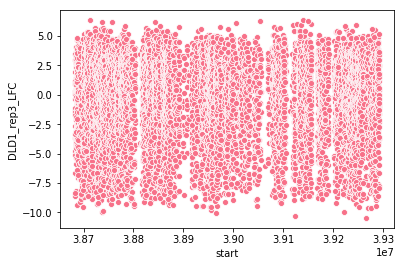

In [63]:
sns.scatterplot(x = "start",y = "DLD1_rep3_LFC", data= mageck_cis_regulatory_regions)

In [64]:
repressor_names =  jaspar.loc[repressor_ids].name

In [65]:
activator_names = jaspar.loc[activator_ids].name

In [66]:
tight_3_score_thresholds = jaspar_fdrs.apply(lambda x : x.loc[tightest_3_thrs.loc[x.name]] if x.name in tightest_3_thrs.dropna().index else None, axis = 1)



In [67]:


tightest_3_thrs = fdr_level_counts[3,"U2OS_WT"].apply(lambda x: x.idxmin(x.notna()),axis=1).rename("tight3")
tightest_5_thrs = fdr_level_counts[5,"U2OS_WT"].apply(lambda x: x.idxmin(x.notna()),axis=1).rename("tight5")



In [68]:
# out =  jaspar_fdrs.apply( lambda j: j.apply(
#     lambda f:
# motif_hits_by_jid_start.loc[j.name].loc[lambda x:x.score > f].join(quantiles_u2os, on ="target_mutant_start_position",how="inner")\
#                 .loc[lambda q:(q["quantile"]==base_quantile) ].loc[lambda df:~df.index.duplicated()].groupby("filter_color").size()).stack("filter_color"),axis=1)

In [69]:
# jaspar_fdrs.apply( 
#     lambda j: j.apply(
#         lambda f:motif_hits_by_jid_start.loc[j.name].loc[lambda x:x.score > f].join(quantiles_u2os, on ="target_mutant_start_position",how="inner")\
#                 .loc[lambda q:(q["quantile"]==base_quantile) ].loc[lambda df:~df.index.duplicated()].groupby("filter_color").size()),axis=1).iloc[:5]

# motif_hits_by_jid_start.loc[j.name.loc[lambda x:x.score > f].join(quantiles_u2os, on ="target_mutant_start_position",how="inner")\
#     .loc[lambda q:(q["quantile"]==base_quantile) ].loc[lambda df:~df.index.duplicated()].groupby("filter_color").size()

# MOTIF ANALYSIS #

### WHICH MOTIFS ARE FOUND IN REGIONS OF DIFFERENTIAL EXPRESSION BETWEEN WILD-TYPE CELLS? ###

### Which motifs are found in regions of differential expression between WT & perturbed cell types? ###

Do enhancer regions exhibit differential activity in chemical perturbations of the cell types under study? 

We examined the same discrepancy measure in the context of cellular perturbations of U2OS and HCT116 cells. 

First, considering U2OS cells with NFKB1 and NFKB2 knockouts, we created the differential expression sets in the same manner as defined above and found [XXX] enhancer regions to exhibit differential expression activation “NFKB-enhancers”, including [XXX] enhancers with ranksort values which changed by more than 3 STANDARD DEVIATIONS. Sorting these cells to look at only GFP negative cells, we found [XXX] enhancers with ranksort values which changed by 3 STANDARD DEVIATIONS.

Next, considering HCT116 cells subjected to treatment with 2uM gemtabicine, we found [XXX] enhancer regions exhibiting differential expression “GEMTAB-enhancers”. Amongst these, [XXX] of the enhancer regions had a ranksort difference of 3 STANDARD DEVIATIONS. 


In [146]:
diffex

,expressed,unexpressed,oligo
0,DLD1_WT,HCT116_GEM,60
1,DLD1_WT,HCT116_GEM,536
2,DLD1_WT,HCT116_GEM,538
3,DLD1_WT,HCT116_GEM,598
4,DLD1_WT,HCT116_GEM,644
5,DLD1_WT,HCT116_GEM,888
6,DLD1_WT,HCT116_GEM,933
7,DLD1_WT,HCT116_GEM,934
8,DLD1_WT,HCT116_GEM,944
9,DLD1_WT,HCT116_GEM,945


# MOTIF DISCOVERY #

### Which motifs do we discover in the unfiltered intervals ###

In [71]:
intervals = pd.read_csv("../out/0729_intervals.csv")

In [72]:
import xml.etree.ElementTree as ET
root = ET.parse('/Users/ben/src/meme-5.0.5/meme_out_2200/meme.xml').getroot()
#arrays = [[[{e.attrib["letter_id"]: e.text} for e in v if e.attrib["letter_id"] in "ATGC"] for v in c[1].getchildren()[0].getchildren()] for c in root.getchildren()[2].getchildren()]
arrays = [[dict([[e.attrib["letter_id"],np.round( float(e.text) * 100)] for e in v if e.attrib["letter_id"] in "ATGC"]) for v in c[1].getchildren()[0].getchildren()] for c in root.getchildren()[2].getchildren()]

from Bio.motifs import jaspar
import io
import Bio
from Bio.Alphabet import IUPAC
motifs_string = "\n".join([">TEST{0} {0}\n".format(i) + "\n".join([k + " ["+" ".join([str(int(d[k])) for d in positions] ) +"]" for k in "ATGC"]) 
     for i, positions in enumerate(arrays)])
f = io.StringIO(motifs_string)
meme_motifs = jaspar.read(f,"jaspar")
intervals["bioseq"] = intervals.seq.apply(lambda x: Bio.Seq.Seq(x,alphabet = Bio.Alphabet.IUPAC.IUPACUnambiguousDNA()))

for mm in meme_motifs: mm.pseudocounts = 1

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  after removing the cwd from sys.path.


### Which motifs do we discover in the expressed oligos? ###

In [73]:
#[TODO] run meme on the expressed oligos only, using the negative null set as the background control

### How do the set of discovered motifs compare to the reference set? ###

In [74]:
jaspar = z2_save_jaspar.load_jaspar()

In [75]:
memes =pd.Series(meme_motifs)

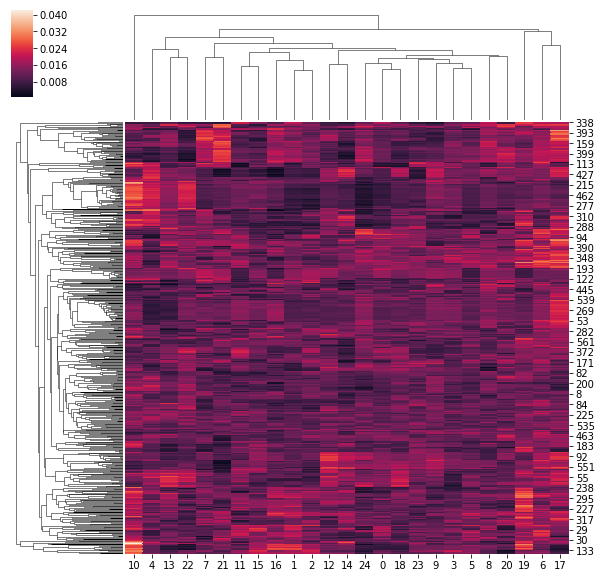

In [76]:
jaspar_array = np.array(list(e for e in jaspar.pwm.apply(lambda x: [e for k in "ATGC" for e in list(x[k])+([0]*(25 - len(x[k])))]).values))
memes_array = np.array(list(e for e in memes.apply(lambda x: [e for k in "ATGC" for e in list(x.pwm[k])+([0]*(25 - len(x.pwm[k])))]).values))
sns.clustermap(np.matmul( (jaspar_array / jaspar_array.sum(axis=1)[:,np.newaxis]),(memes_array/memes_array.sum(axis=1)[:,np.newaxis]).T))

In [77]:
print("HI")

HI


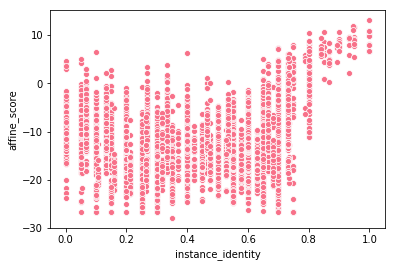

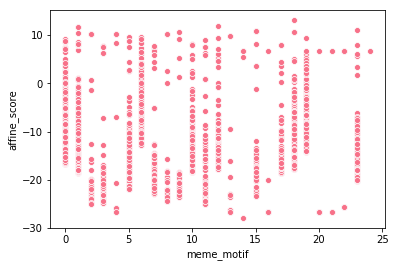

In [78]:
meme_hits = memes.apply(lambda mm: intervals.apply(lambda x:[ e for e in  mm.pssm.search(x.bioseq)] , axis = 1))
meme_unstacked =pd.concat(
    [meme_hits.stack().groupby(level=[0,1]).apply(lambda g: pd.Series([e[0] for r in g for e in r])).rename("instance_idx"),
     meme_hits.stack().groupby(level=[0,1]).apply(lambda g: pd.Series([e[1] for r in g for e in r])).rename("instance_score")]
    ,axis = 1)

meme_unstacked.index.levels[0].name="meme_motif"
meme_unstacked.index.levels[1].name="interval_id"
meme_unstacked = meme_unstacked.reset_index(level=["meme_motif","interval_id"]).reset_index(drop = True)
meme_unstacked = meme_unstacked.join(memes.apply(lambda x:str(x.consensus)).rename("consensus"),on = "meme_motif")
meme_unstacked = meme_unstacked.join(intervals[["start","end","seq"]], on = "interval_id")
meme_unstacked["instance_position"] = meme_unstacked.apply(
    lambda x:x.start + x.instance_idx if x.instance_idx >= 0 else x.end + x.instance_idx,axis =1)
meme_unstacked["instance_seq"] = meme_unstacked.apply(lambda x:x.seq[x.instance_position - x.start:][:len(x.consensus)], axis = 1)

#LOADS BIOLOGICAL MOTIFS AND SCANS ALL SUBREGIONS FOR OCCURENCES
from pyfaidx import Fasta
sequences_fa = Fasta('/Users/ben/genomes/GRCh38.primary_assembly.genome.fa')
chrseq = str(sequences_fa["chr22"])
region_bounds=[ 38699734, 39291007]
background = dict([[l,chrseq[region_bounds[0]:region_bounds[1]].count(l) / len(chrseq[region_bounds[0]:region_bounds[1]])] for l in "ATGC"])

memes_patser = memes.apply(lambda x: x.pssm.distribution(background=background, precision=10**3).threshold_patser())
meme_unstacked = meme_unstacked.join(memes_patser.rename("motif_threshold_patser"),on="meme_motif")
meme_unstacked["affine_score"] = meme_unstacked["instance_score"] - meme_unstacked["motif_threshold_patser"]
meme_unstacked["instance_identity"] = meme_unstacked[["instance_seq","consensus"]].apply(lambda x: float(len([ i for i,l in enumerate(x.instance_seq) if l == x.consensus[i]]))/len(x.consensus),axis=1)


sns.scatterplot( x = "instance_identity", y = "affine_score", data= meme_unstacked)
plt.figure()
sns.scatterplot( x = "meme_motif", y = "affine_score", data= meme_unstacked)

## For Lin ##
1. A list of the most statistically enrich "activators" -- Does this mean "regions"? or motifs?
2. Currently working on a small molecule experiment which inhibits FOSL1, [...?]
3. A list of the most enriched subregions, putting emphasis on finding one which is highly enriched, but does not identify a fold-change repressor. 

In [79]:
LEVEL_DIFFERENT_CANDIDATES = motif_filter_color_counts.reset_index().\
    loc[lambda df: df.exp_type.isin(["U2OS_WT","U2OS_NFKB","HCT116_WT","HCT116_GEM","DLD1_WT"])].\
    loc[lambda df: (df["quantile"] == .75) & (df["affine_score_threshold"] == 2)  & (df["filter_color"] == 1)]\


In [80]:
LEVEL_DIFFERENT_TABLE = LEVEL_DIFFERENT_CANDIDATES.set_index(["exp_type","jaspar_id"]).color_1_enrichment.unstack().T.join(jaspar.name).fillna(0)

In [81]:
# LEVEL_DIFFERENT_TABLE = LEVEL_DIFFERENT_CANDIDATES.unstack("exp_type")["color_3_enrichment"].fillna(0)

In [82]:
GEM_MOTIFS = (LEVEL_DIFFERENT_TABLE.HCT116_GEM - LEVEL_DIFFERENT_TABLE.HCT116_WT).loc[lambda x: x> 0]

In [83]:
len(motif_oligos_data.set_index("jaspar_id").loc[lambda x: (x.score > (x.threshold_fdr_005)) & (x.score > (x.threshold_patser))])

77165

In [84]:
len(motif_oligos_data.set_index("jaspar_id").loc[lambda x: (x.score > (x.threshold_fdr_005 -1)) & (x.score > (x.threshold_patser-1))])

156988

In [85]:
GEM_MOTIFS

jaspar_id
12     0.003227
14     0.000151
30     0.063181
45     0.083045
53     0.006009
73     0.210084
76     0.020528
105    0.014471
113    0.058962
464    0.255102
517    0.240385
531    0.079114
dtype: float64

In [86]:
oligos_of_interest = GEM_MOTIFS.to_frame().join(
    motif_oligos_data.set_index("jaspar_id").loc[lambda x: (x.score > (x.threshold_fdr_005 )) ])

In [87]:
oligos_with_experiments = \
    oligos_of_interest.reset_index()[["jaspar_id","oligo","score","threshold_fdr_005"]].join(oligos_by_exp.set_index("oligo"),on="oligo")



In [88]:
high_scoring_owe = oligos_with_experiments

In [89]:
norm_expressions = oligos_by_exp.groupby("exp_type").mu.mean()

In [90]:
high_scoring_owe.groupby(["jaspar_id","exp_type"]).mu.mean().unstack() / norm_expressions

exp_type,DLD1_WT,HCT116_GEM,HCT116_WT,U2OS_NFKB,U2OS_WT
jaspar_id,,,,,
12,1.002470,0.997801,1.002021,0.974979,0.984807
14,0.993397,0.991493,0.978774,1.021305,1.000725
30,1.003598,0.999753,1.003737,1.044702,1.009992
45,1.035818,1.038265,1.047576,1.534375,1.304570
53,0.990859,0.994030,0.965448,1.010362,1.006978
73,0.898190,0.933975,0.884559,0.847086,0.896494
76,0.984015,0.985730,0.977092,0.976732,0.982332
105,0.952361,0.963479,0.963847,0.938778,0.900792
113,0.979625,0.974240,0.973705,0.975356,0.982242


In [91]:
bins = np.linspace(region_bounds[0],region_bounds[1],10)

In [92]:
these_motifs = motif_oligos_data.loc[lambda x: x.jaspar_id == 31].drop_duplicates(["jaspar_id","position"])

In [93]:
std_expression_by_exp = oligos_by_exp.groupby("exp_type").mu.std()

In [94]:
mean_expression_by_exp_nm = oligos_by_exp.groupby("exp_nm").mu.mean()
mean_stds_by_exp_nm = oligos_by_exp.groupby("exp_nm").mu.std()

In [95]:

out_means_by_nm =  jaspar.apply(lambda j: 
    (oligos_by_exp.loc[lambda x: (x.oligo.isin(\
                                              motif_oligos_data.loc[lambda x: x.jaspar_id == j.name].oligo\
                                                 )) & x.oligo.isin(wt_oligos.index)].groupby("exp_nm").mu.mean() - mean_expression_by_exp_nm)/mean_stds_by_exp_nm,axis=1)





out_stds_by_nm = jaspar.apply(lambda j: 
    oligos_by_exp.loc[lambda x: (x.oligo.isin(\
                                              motif_oligos_data.loc[lambda x: x.jaspar_id == j.name].oligo\
                                                 )) & x.oligo.isin(wt_oligos.index)].groupby("exp_nm").mu.std()/mean_stds_by_exp_nm,axis=1)


In [96]:
out_means_by_nm.columns.name = "exp_nm"
out_stds_by_nm.columns.name = "exp_nm"

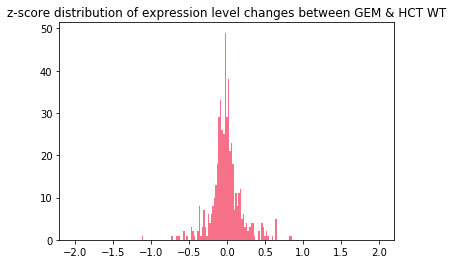

<Figure size 432x288 with 0 Axes>

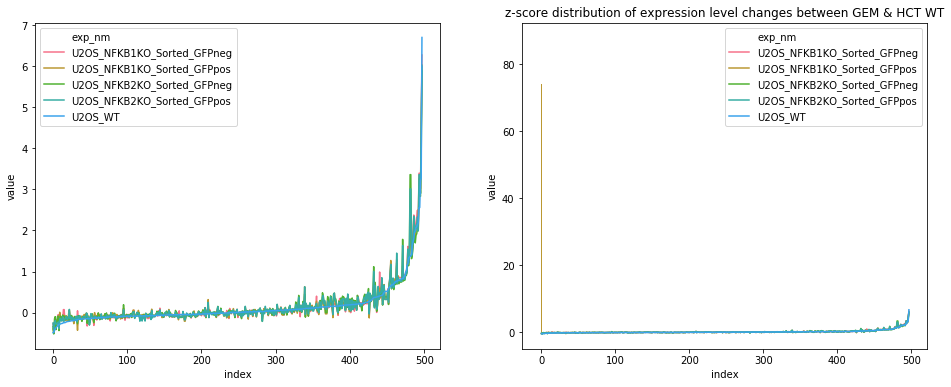

<Figure size 432x288 with 0 Axes>

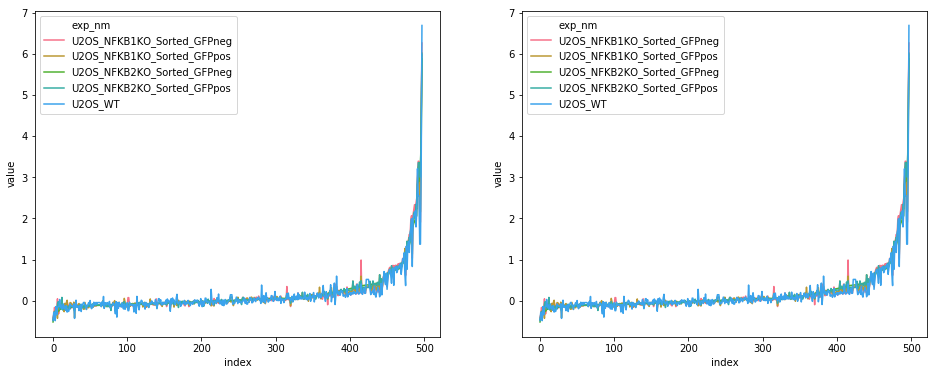

In [97]:

new_outval = (out_means_by_nm.U2OS_WT - out_means_by_nm.U2OS_NFKB2KO_Sorted_GFPneg) / (out_stds_by_nm.U2OS_WT + out_stds_by_nm.U2OS_NFKB2KO_Sorted_GFPneg)*2


with_sort = out_means_by_nm.reset_index().sort_values("U2OS_WT").reset_index(drop=True).reset_index().set_index("jaspar_id")

bins = np.linspace(-2,2,200)
plt.hist(new_outval,bins = bins)
plt.gca().set_title("z-score distribution of expression level changes between GEM & HCT WT")

plt.figure()

f, subs = plt.subplots(1,2)
f = plt.gcf()
f.set_size_inches(16,6)
plt.sca(subs[0])
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])

plt.sca(subs[1])

with_sort2 = out_means_by_nm.reset_index().sort_values("U2OS_WT").reset_index(drop=True).reset_index().set_index("jaspar_id")
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort2.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])


LIN_DIFFERENTIAL_U2OSWT_VS_NFKB2_EXPRESSION_ZSCORES = new_outval.rename("zscore_wt_minus_neg").to_frame().join(jaspar)[["name","consensus","zscore_wt_minus_neg"]]\
    .join(out_means_by_nm[["U2OS_WT","U2OS_NFKB2KO_Sorted_GFPneg"]].rename(lambda x: x+"_MEAN",axis="columns"))\
    .join(out_stds_by_nm[["U2OS_WT","U2OS_NFKB2KO_Sorted_GFPneg"]].rename(lambda x: x+"_STD",axis="columns"))

LIN_DIFFERENTIAL_U2OSWT_VS_NFKB2_EXPRESSION_ZSCORES.to_csv("../data/0808_LIN_DIFFERENTIAL_U2OSWT_VS_NFKB2_EXPRESSION_ZSCORES.csv")

new_outval = (out_means_by_nm.U2OS_NFKB2KO_Sorted_GFPneg - out_means_by_nm.U2OS_NFKB2KO_Sorted_GFPpos) / (out_stds_by_nm.U2OS_NFKB2KO_Sorted_GFPpos + out_stds_by_nm.U2OS_NFKB2KO_Sorted_GFPneg)*2


with_sort = out_means_by_nm.reset_index().sort_values("U2OS_NFKB2KO_Sorted_GFPneg").reset_index(drop=True).reset_index().set_index("jaspar_id")

bins = np.linspace(-2,2,200)
plt.hist(new_outval,bins = bins)
plt.gca().set_title("z-score distribution of expression level changes between GEM & HCT WT")

plt.figure()

f, subs = plt.subplots(1,2)
f = plt.gcf()
f.set_size_inches(16,6)
plt.sca(subs[0])
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])

plt.sca(subs[1])

with_sort2 = out_means_by_nm.reset_index().sort_values("U2OS_NFKB2KO_Sorted_GFPneg").reset_index(drop=True).reset_index().set_index("jaspar_id")
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort2.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])

LIN_DIFFERENTIAL_U2OS_NFKB2_PLUS_VS_NFKB2_MINUS_EXPRESSION_ZSCORES = new_outval.rename("zscore_neg_minus_pos").to_frame().join(jaspar)[["name","consensus","zscore_neg_minus_pos"]]\
    .join(out_means_by_nm[["U2OS_NFKB2KO_Sorted_GFPpos","U2OS_NFKB2KO_Sorted_GFPneg"]].rename(lambda x: x+"_MEAN",axis="columns"))\
    .join(out_stds_by_nm[["U2OS_NFKB2KO_Sorted_GFPpos","U2OS_NFKB2KO_Sorted_GFPneg"]].rename(lambda x: x+"_STD",axis="columns"))

LIN_DIFFERENTIAL_U2OS_NFKB2_PLUS_VS_NFKB2_MINUS_EXPRESSION_ZSCORES.to_csv("../data/0808_LIN_DIFFERENTIAL_U2OS_NFKB2_PLUS_VS_NFKB2_MINUS_EXPRESSION_ZSCORES.csv")

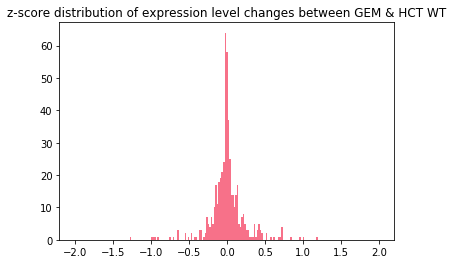

<Figure size 432x288 with 0 Axes>

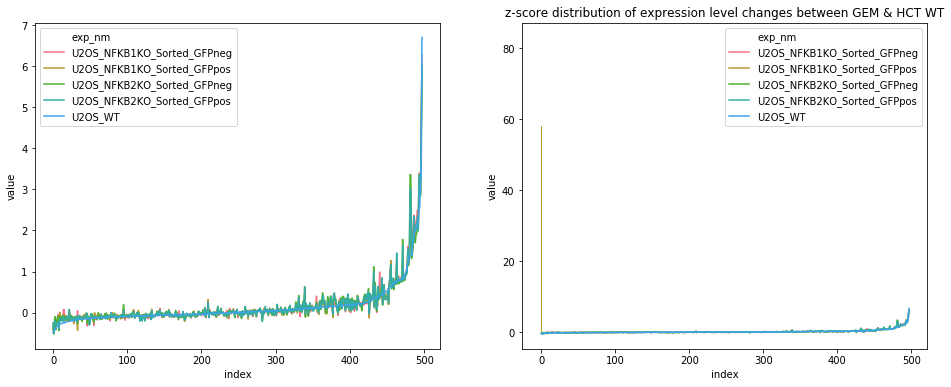

<Figure size 432x288 with 0 Axes>

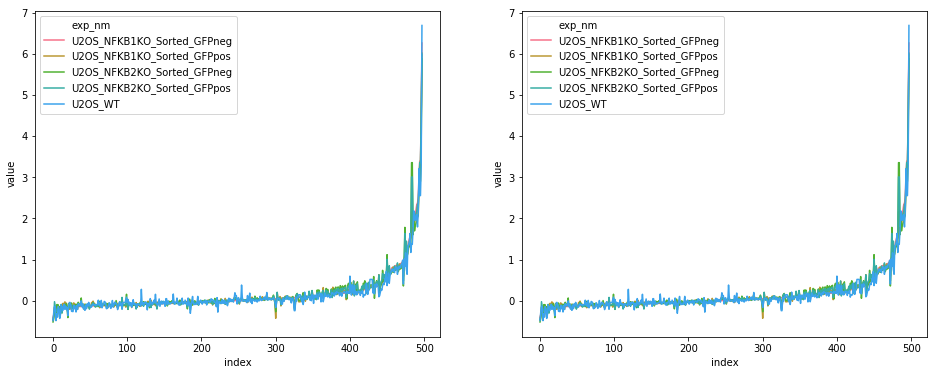

In [98]:

new_outval = (out_means_by_nm.U2OS_WT - out_means_by_nm.U2OS_NFKB1KO_Sorted_GFPneg) / (out_stds_by_nm.U2OS_WT + out_stds_by_nm.U2OS_NFKB1KO_Sorted_GFPneg)*2


with_sort = out_means_by_nm.reset_index().sort_values("U2OS_WT").reset_index(drop=True).reset_index().set_index("jaspar_id")

bins = np.linspace(-2,2,200)
plt.hist(new_outval,bins = bins)
plt.gca().set_title("z-score distribution of expression level changes between GEM & HCT WT")

plt.figure()

f, subs = plt.subplots(1,2)
f = plt.gcf()
f.set_size_inches(16,6)
plt.sca(subs[0])
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])

plt.sca(subs[1])

with_sort2 = out_means_by_nm.reset_index().sort_values("U2OS_WT").reset_index(drop=True).reset_index().set_index("jaspar_id")
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort2.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])


LIN_DIFFERENTIAL_U2OSWT_VS_NFKB1_EXPRESSION_ZSCORES = new_outval.rename("zscore_wt_minus_neg").to_frame().join(jaspar)[["name","consensus","zscore_wt_minus_neg"]]\
    .join(out_means_by_nm[["U2OS_WT","U2OS_NFKB1KO_Sorted_GFPneg"]].rename(lambda x: x+"_MEAN",axis="columns"))\
    .join(out_stds_by_nm[["U2OS_WT","U2OS_NFKB1KO_Sorted_GFPneg"]].rename(lambda x: x+"_STD",axis="columns"))

LIN_DIFFERENTIAL_U2OSWT_VS_NFKB1_EXPRESSION_ZSCORES.to_csv("../data/0808_LIN_DIFFERENTIAL_U2OSWT_VS_NFKB1_EXPRESSION_ZSCORES.csv")

new_outval = (out_means_by_nm.U2OS_NFKB1KO_Sorted_GFPneg - out_means_by_nm.U2OS_NFKB1KO_Sorted_GFPpos) / (out_stds_by_nm.U2OS_NFKB1KO_Sorted_GFPpos + out_stds_by_nm.U2OS_NFKB1KO_Sorted_GFPneg)*2


with_sort = out_means_by_nm.reset_index().sort_values("U2OS_NFKB1KO_Sorted_GFPneg").reset_index(drop=True).reset_index().set_index("jaspar_id")

bins = np.linspace(-2,2,200)
plt.hist(new_outval,bins = bins)
plt.gca().set_title("z-score distribution of expression level changes between GEM & HCT WT")

plt.figure()

f, subs = plt.subplots(1,2)
f = plt.gcf()
f.set_size_inches(16,6)
plt.sca(subs[0])
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])

plt.sca(subs[1])

with_sort2 = out_means_by_nm.reset_index().sort_values("U2OS_NFKB1KO_Sorted_GFPneg").reset_index(drop=True).reset_index().set_index("jaspar_id")
sns.lineplot(x="index",y="value", hue="exp_nm", data = with_sort2.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_nm.str.contains("U2OS")])

LIN_DIFFERENTIAL_U2OS_NFKB1_PLUS_VS_NFKB1_MINUS_EXPRESSION_ZSCORES = new_outval.rename("zscore_neg_minus_pos").to_frame().join(jaspar)[["name","consensus","zscore_neg_minus_pos"]]\
    .join(out_means_by_nm[["U2OS_NFKB1KO_Sorted_GFPpos","U2OS_NFKB1KO_Sorted_GFPneg"]].rename(lambda x: x+"_MEAN",axis="columns"))\
    .join(out_stds_by_nm[["U2OS_NFKB1KO_Sorted_GFPpos","U2OS_NFKB1KO_Sorted_GFPneg"]].rename(lambda x: x+"_STD",axis="columns"))

LIN_DIFFERENTIAL_U2OS_NFKB1_PLUS_VS_NFKB1_MINUS_EXPRESSION_ZSCORES.to_csv("../data/0808_LIN_DIFFERENTIAL_U2OS_NFKB1_PLUS_VS_NFKB1_MINUS_EXPRESSION_ZSCORES.csv")



In [99]:
LIN_DIFFERENTIAL_U2OS_NFKB2_PLUS_VS_NFKB2_MINUS_EXPRESSION_ZSCORES

,name,consensus,zscore_neg_minus_pos,U2OS_NFKB2KO_Sorted_GFPpos_MEAN,U2OS_NFKB2KO_Sorted_GFPneg_MEAN,U2OS_NFKB2KO_Sorted_GFPpos_STD,U2OS_NFKB2KO_Sorted_GFPneg_STD
jaspar_id,,,,,,,
0,Arnt,CACGTG,0.001445,0.200696,0.203310,1.704850,1.912730
1,Ahr::Arnt,TGCGTG,0.002279,0.024911,0.027662,1.213865,1.199876
2,Ddit3::Cebpa,AGATGCAATCCC,-0.072985,0.103568,0.045711,0.909415,0.676045
3,NFIL3,TTATGTAACGT,-0.055738,-0.047353,-0.071459,0.344468,0.520486
4,Mecom,AAGATAAGATAAGA,-0.139137,-0.026055,-0.093662,0.455380,0.516431
5,FOXF2,CAAACGTAAACAAT,-0.014715,-0.154093,-0.159402,0.320012,0.401614
6,FOXD1,GTAAACAT,-0.042932,-0.091731,-0.105290,0.326290,0.305377
7,Gfi1,CAAATCACTG,-0.022685,-0.001069,-0.015329,0.669616,0.587650
8,Foxq1,TATTGTTTATT,-0.022507,0.103995,0.089385,0.644989,0.653313


In [100]:
mean_expressions_by_exp = oligos_by_exp.groupby("exp_type").mu.mean()

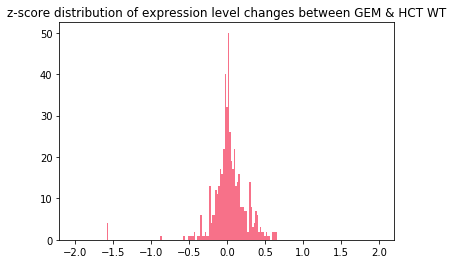

<Figure size 432x288 with 0 Axes>

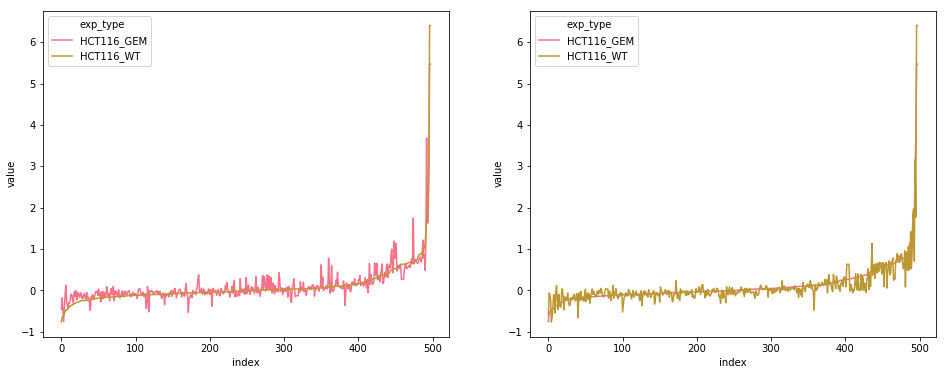

In [101]:
out_means = jaspar.apply(lambda j: 
    (oligos_by_exp.loc[lambda x: (x.oligo.isin(\
                                              motif_oligos_data.loc[lambda x: x.jaspar_id == j.name].oligo\
                                                 )) & x.oligo.isin(wt_oligos.index)].groupby("exp_type").mu.mean() - mean_expressions_by_exp)/std_expression_by_exp,axis=1)





out_stds = jaspar.apply(lambda j: 
    oligos_by_exp.loc[lambda x: (x.oligo.isin(\
                                              motif_oligos_data.loc[lambda x: x.jaspar_id == j.name].oligo\
                                                 )) & x.oligo.isin(wt_oligos.index)].groupby("exp_type").mu.std()/std_expression_by_exp ,axis=1)


new_outval = (out_means.HCT116_GEM - out_means.HCT116_WT) / (out_stds.HCT116_GEM + out_stds.HCT116_WT)*2


with_sort = out_means.reset_index().sort_values("HCT116_WT").reset_index(drop=True).reset_index().set_index("jaspar_id")

bins = np.linspace(-2,2,200)
plt.hist(new_outval,bins = bins)
plt.gca().set_title("z-score distribution of expression level changes between GEM & HCT WT")

plt.figure()

f, subs = plt.subplots(1,2)
f = plt.gcf()
f.set_size_inches(16,6)
plt.sca(subs[0])
sns.lineplot(x="index",y="value", hue="exp_type", data = with_sort.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_type.str.contains("HCT")])

plt.sca(subs[1])

with_sort2 = out_means.reset_index().sort_values("HCT116_GEM").reset_index(drop=True).reset_index().set_index("jaspar_id")
sns.lineplot(x="index",y="value", hue="exp_type", data = with_sort2.reset_index().melt(id_vars=["jaspar_id","index"]).loc[lambda x: x.exp_type.str.contains("HCT")])


LIN_HCT116_DIFFERENTIAL_EXPRESSION_ZSCORES = new_outval.rename("zscore").to_frame().join(jaspar)[["name","consensus","zscore"]]\
    .join(out_means[["HCT116_GEM","HCT116_WT"]].rename(lambda x: x+"_MEAN",axis="columns"))\
    .join(out_stds[["HCT116_GEM","HCT116_WT"]].rename(lambda x: x+"_STD",axis="columns"))

LIN_HCT116_DIFFERENTIAL_EXPRESSION_ZSCORES.to_csv("../data/0808_LIN_HCT116_DIFFERENTIAL_EXPRESSION_ZSCORES.csv")

# APPENDIX #
Additional figureds which may be useful in understanding the data

### APPENDIX A: RANKSORT DISCREPANCIES ###
The selection of APOBEC-differential-activators was performed based on a change in the ranksorted expression levels between the two APOBEC expressing cell types under study. For this to be a valid measure, we would hope that the majority of activators were discovered in both cell types and that their differences fell under the differential expression threshold. 

This is the case to a limited extent. 

(array([4785., 3526., 3076., 2413., 2459., 1863., 1613., 1574., 1275.,
        1594.,  976.,  704.,  742.,  795.,  579.,  376.,  320.,  366.,
         432.]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900, 950]),
 <a list of 19 Patch objects>)

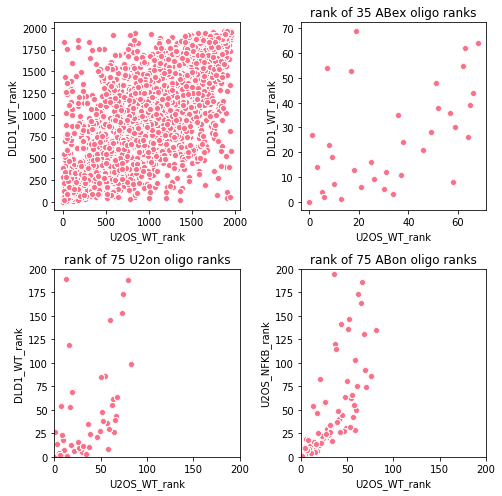

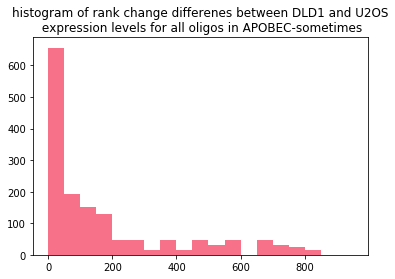

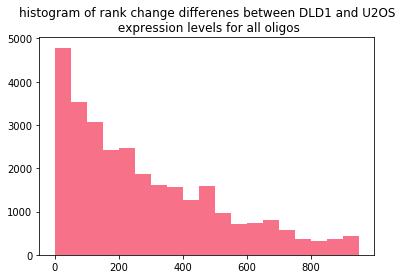

In [102]:

f,subs = plt.subplots(2,2)
f.set_size_inches(7,7)
plt.sca(subs[0][0])
sns.scatterplot(obe.U2OS_WT_rank,obe.DLD1_WT_rank)

plt.sca(subs[0][1])

sns.scatterplot(
    x = "U2OS_WT_rank",
    y = "DLD1_WT_rank",
    data =  obe.loc[lambda x: x.oligo.isin(ABon_ids)],
)
plt.gca().set_title(f"rank of {len(ABon_ids)} ABex oligo ranks")


plt.sca(subs[1][0])
sns.scatterplot(
    x = "U2OS_WT_rank",
    y = "DLD1_WT_rank",
    data =  obe.loc[lambda x: x.oligo.isin(U2on_ids)],
)
plt.gca().set_title(f"rank of {len(U2on_ids)} U2on oligo ranks")
plt.tight_layout()

plt.gca().set_xlim([0,200])
plt.gca().set_ylim([0,200])


plt.sca(subs[1][1])
sns.scatterplot(
    x = "U2OS_WT_rank",
    y = "U2OS_NFKB_rank",
    data =  obe.loc[lambda x: x.oligo.isin(U2on_ids)],
)
plt.gca().set_title(f"rank of {len(U2on_ids)} ABon oligo ranks")
plt.tight_layout()

plt.gca().set_xlim([0,200])
plt.gca().set_ylim([0,200])

f = plt.figure()
ax = plt.gca()
ax.set_title ("histogram of rank change differenes between DLD1 and U2OS\n expression levels for all oligos in APOBEC-sometimes")

plt.hist(  (obe.loc[lambda x:x.oligo.isin(ABst_ids)].DLD1_WT_rank - 
            obe.loc[lambda x:x.oligo.isin(ABst_ids)].U2OS_WT_rank ).abs() ,
        bins = np.arange(0,1000,50))

f = plt.figure()
ax = plt.gca()
ax.set_title ("histogram of rank change differenes between DLD1 and U2OS\n expression levels for all oligos")

plt.hist(  (obe.DLD1_WT_rank - obe.U2OS_WT_rank ).abs(),
         bins = np.arange(0,1000,50) )


# obe_win = obe.loc[lambda x: x.oligo.isin(U2on_ids)]
# from scipy import stats
# def r2(x, y):
#     return stats.pearsonr(x, y)[0] ** 2

# def pval(x, y):
#     return stats.pearsonr(x, y)[1] ** 2

# sns.jointplot("U2OS_WT_rank","DLD1_WT_rank", kind="reg", stat_func=r2,data = obe_win)
# #sns.regplot("U2OS_WT_rank","DLD1_WT_rank",data = obe_win)

In [103]:
EXP_activator_oligos

exp  oligo   index  n_bcs  n_transcripts  \
exp_nm  exp                                                                    
DLD1_WT DLD1_WT_BR1 416     DLD1_WT_BR1      5       5     56            177   
                    492     DLD1_WT_BR1      6       6     82            378   
                    572     DLD1_WT_BR1      7       7     62            197   
                    647     DLD1_WT_BR1      8       8    120            708   
                    1447    DLD1_WT_BR1     24      20    121            335   
                    1607    DLD1_WT_BR1     26      22     69            244   
                    4674    DLD1_WT_BR1     66      62    119            351   
                    19834   DLD1_WT_BR1    257     253      1              3   
                    19944   DLD1_WT_BR1    260     255      8             40   
                    20007   DLD1_WT_BR1    261     256    156            888   
                    20048   DLD1_WT_BR1    262     257    146            582   
                    20128   DLD1_WT_BR1    263     258    283            929   
                    32410   DLD1_WT_BR1    420     413    353           1057   
                    32627   DLD1_WT_BR1    423     416     34             98   
                    38035   DLD1_WT_BR1    491     484     30             90   
                    38738   DLD1_WT_BR1    500     493    122            381   
                    38815   DLD1_WT_BR1    501     494    244            702   
                    38895   DLD1_WT_BR1    502     495    472           1567   
                    40456   DLD1_WT_BR1    521     514    348           1143   
                    60506   DLD1_WT_BR1    780     769      7             26   
                    62949   DLD1_WT_BR1    815     800     89            532   
                    63025   DLD1_WT_BR1    816     801    282           2921   
                    63105   DLD1_WT_BR1    817     802    224            898   
                    63185   DLD1_WT_BR1    818     803    116            551   
                    63816   DLD1_WT_BR1    826     811    225            691   
                    66244   DLD1_WT_BR1    859     843      1              3   
                    67826   DLD1_WT_BR1    889     871     63            197   
                    72903   DLD1_WT_BR1    958     937      1              4   
                    72975   DLD1_WT_BR1    959     938     43            175   
                    73055   DLD1_WT_BR1    960     939     99            557   
...                                 ...    ...     ...    ...            ...   
U2OS_WT U2OS_WT_BR2 107770  U2OS_WT_BR2   1414  145492     19             79   
                    107850  U2OS_WT_BR2   1415  145493    105            467   
                    107930  U2OS_WT_BR2   1416  145494     94            341   
                    109673  U2OS_WT_BR2   1438  145516    123            659   
                    109752  U2OS_WT_BR2   1439  145517     55            261   
                    114860  U2OS_WT_BR2   1506  145582      9             70   
                    119244  U2OS_WT_BR2   1566  145638     24            134   
                    119915  U2OS_WT_BR2   1576  145648    122            516   
                    120072  U2OS_WT_BR2   1578  145650     21             88   
                    120152  U2OS_WT_BR2   1579  145651     12             62   
                    126030  U2OS_WT_BR2   1654  145726     43            327   
                    133588  U2OS_WT_BR2   1751  145822     69            441   
                    133668  U2OS_WT_BR2   1752  145823    234           2539   
                    133748  U2OS_WT_BR2   1753  145824    250           6263   
                    133828  U2OS_WT_BR2   1754  145825    156           2161   
                    133908  U2OS_WT_BR2   1755  145826    241           1716   
                    133988  U2OS_WT_BR2   1756  145827    133            519   
                    137366  U2OS_WT_

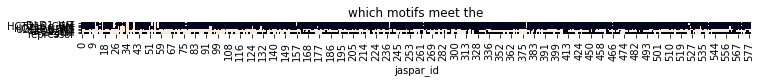

In [124]:
thr = 2
color3 = motif_filter_color_counts.reset_index()\
    .loc[lambda x:(x["quantile"] ==.9) & (x["affine_score_threshold"] == thr) &  (x["color_3_enrichment"] >0 ) ]

U2_oligos =pd.concat( [
                       pd.Series("activator",index = EXP_activator_oligos.loc["U2OS_WT"].oligo),
pd.Series("repressor",index = EXP_repressor_oligos.loc["U2OS_WT"].oligo),
    pd.Series("null",index = EXP_null_oligos.loc["U2OS_WT"].oligo)
],axis = 0).rename("otype")




#APPENDIX: U2OS CELL TYPE ANALYSIS OF ENRICHMENTS
oligo_types = U2_oligos.to_frame().set_index("otype",append=True).assign(val=1).reset_index().pivot_table(index="oligo",columns="otype")["val"].fillna(0)
modata_thr = motif_oligos_data.loc[lambda x:(x.affine_score > thr) & (x.is_overlapping_wt)].set_index("jaspar_id").sort_index()
motif_wt_oligo_counts = jaspar.reset_index().apply(lambda x: len(modata_thr.loc[x.jaspar_id]) if x.jaspar_id in modata_thr.index.get_level_values(0) else 0,axis =1)

oligo_type_counts =  modata_thr.groupby("jaspar_id").apply(lambda g1:
oligo_types.apply( 
    lambda y:
y.loc[[e for e in g1.oligo.unique() if e in y.index]].sum()
))
oligo_type_fracs = oligo_type_counts.apply(lambda x: x / x.sum(), axis =1).fillna(0) / oligo_type_counts.mean(axis=0)
color_counts_2d = (motif_filter_color_counts.reset_index()\
    .loc[lambda x:(x["quantile"] ==.95) & (x["affine_score_threshold"] == 1) ]\
    .groupby(["jaspar_id","exp_type"]).apply(lambda x: x.color_2_enrichment.max()+x.color_3_enrichment.max()).unstack() ) * 1 
color_counts_2d = color_counts_2d /color_counts_2d.mean(axis=0)

plt.gcf().set_size_inches(12,3)
plt.gca().set_title("which motifs meet the")
sns.heatmap(pd.concat([color_counts_2d, oligo_type_fracs[["activator","null","repressor"]]],axis = 1).fillna(0).T>0,square=True,cbar=False)